In [1]:
# read nc output from WAOM 10km run

import xarray as xr
import pandas as p
import numpy as np
import numpy.ma as ma
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib as mpl
# mpl.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.dates as dates
from matplotlib.ticker import NullFormatter
from matplotlib.colors import LinearSegmentedColormap   # for custom colormaps
from matplotlib import colors
import matplotlib.path as mpath
import cmocean

from datetime import datetime, timedelta

from netCDF4 import Dataset
from netCDF4 import num2date, date2num

import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import os

import gsw
import pyresample
from xgcm import Grid

from dask.distributed import Client
import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)


In [2]:
client = Client()
client

<Client: 'tcp://127.0.0.1:35541' processes=7 threads=28, memory=251.18 GiB>

In [3]:
# read grid file for lon/lat coordinates
dg = xr.open_dataset("/g/data3/hh5/tmp/access-om/fbd581/ROMS/waom4_frc/waom4extend_grd.nc")
lat_rho_4km= dg.variables["lat_rho"]
lon_rho_4km = dg.variables["lon_rho"]
lat_u_4km= dg.variables["lat_u"]
lon_u_4km = dg.variables["lon_u"]
lat_v_4km= dg.variables["lat_v"]
lon_v_4km = dg.variables["lon_v"]
cor_4km = dg.variables["f"]
pm_4km = dg.variables["pm"]
pn_4km = dg.variables["pn"]
zice_4km = dg.variables["zice"]
h_4km = dg.variables["h"]
dg.close()
print('Print lon/lat_rho shapes',lon_rho_4km.shape, lat_rho_4km.shape)
print('Print lon/lat_rho shapes',lon_rho_4km[0:-1,0:-1].shape, lat_rho_4km[0:-1,0:-1].shape)

0.3.0
Print lon/lat_rho shapes (1400, 1575) (1400, 1575)
Print lon/lat_rho shapes (1399, 1574) (1399, 1574)


In [4]:
# read grid file for lon/lat coordinates
dg = xr.open_dataset("/g/data/hh5/tmp/access-om/fbd581/ROMS/waom10_frc/waom10extend_grd.nc")
lat_rho_10km= dg.variables["lat_rho"]
lon_rho_10km = dg.variables["lon_rho"]
lat_u_10km= dg.variables["lat_u"]
lon_u_10km = dg.variables["lon_u"]
lat_v_10km= dg.variables["lat_v"]
lon_v_10km = dg.variables["lon_v"]
cor_10km = dg.variables["f"]
pm_10km = dg.variables["pm"]
pn_10km = dg.variables["pn"]
zice_10km = dg.variables["zice"]
h_10km = dg.variables["h"]
dg.close()

In [5]:
%%time
path_ECCO2_10_mdA = '/g/data/hh5/tmp/access-om/fbd581/ROMS/OUTPUT/waom10extend_shflim_S_0.25Q/output_01-20yr_ModDragA/'
# ds = xr.open_mfdataset(paths='/g/data/hh5/tmp/access-om/fbd581/ROMS/OUTPUT/waom4extend_shflim_S_0.25Q/output_01-10yr_ModDragD/ocean_avg_0010.nc')#, chunks={'eta_rho': '200MB'}, parallel=True, decode_times=False)
ds = xr.open_mfdataset(path_ECCO2_10_mdA + "ocean_avg_00*.nc")
temp_10_mdA= ds.variables["temp"]
salt_10_mdA= ds.variables["salt"]
zeta_10_mdA= ds.variables["zeta"]
melt_10_mdA= ds.variables["m"]
shflux_10_mdA= ds.variables["shflux"]
ssflux_10_mdA= ds.variables["ssflux"]
ds = ds.set_coords(['Cs_r', 'Cs_w', 'hc', 'h', 'Vtransform'])
Zo_rho = (ds.hc * ds.s_rho + ds.Cs_r * ds.h) / (ds.hc + ds.h)
z_rho_10_mdA = ds.zeta + (ds.zeta + ds.h) * Zo_rho + ds.zice
Zo_w = (ds.hc * ds.s_w + ds.Cs_w * ds.h) / (ds.hc + ds.h)
z_w_10_mdA = ds.zeta + (ds.zeta + ds.h) * Zo_w + ds.zice
del Zo_rho, Zo_w
ds.close()



CPU times: user 7.3 s, sys: 1.34 s, total: 8.64 s
Wall time: 24.2 s


In [6]:
%%time
path_ECCO2_10_mdB = '/g/data/hh5/tmp/access-om/fbd581/ROMS/OUTPUT/waom10extend_shflim_S_0.25Q/output_01-20yr_ModDragB/'
ds = xr.open_mfdataset(path_ECCO2_10_mdB + "ocean_avg_00*.nc")
temp_10_mdB= ds.variables["temp"]
salt_10_mdB= ds.variables["salt"]
zeta_10_mdB= ds.variables["zeta"]
melt_10_mdB= ds.variables["m"]
shflux_10_mdB= ds.variables["shflux"]
ssflux_10_mdB= ds.variables["ssflux"]
ds = ds.set_coords(['Cs_r', 'Cs_w', 'hc', 'h', 'Vtransform'])
Zo_rho = (ds.hc * ds.s_rho + ds.Cs_r * ds.h) / (ds.hc + ds.h)
z_rho_10_mdB = ds.zeta + (ds.zeta + ds.h) * Zo_rho + ds.zice
Zo_w = (ds.hc * ds.s_w + ds.Cs_w * ds.h) / (ds.hc + ds.h)
z_w_10_mdB = ds.zeta + (ds.zeta + ds.h) * Zo_w + ds.zice
del Zo_rho, Zo_w
ds.close()



CPU times: user 6.47 s, sys: 1.23 s, total: 7.7 s
Wall time: 15 s


In [7]:
%%time
path_ECCO2_10_mdC = '/g/data/hh5/tmp/access-om/fbd581/ROMS/OUTPUT/waom10extend_shflim_S_0.25Q/output_01-20yr_ModDragC/'
ds = xr.open_mfdataset(path_ECCO2_10_mdC + "ocean_avg_00*.nc")
temp_10_mdC= ds.variables["temp"]
salt_10_mdC= ds.variables["salt"]
zeta_10_mdC= ds.variables["zeta"]
melt_10_mdC= ds.variables["m"]
shflux_10_mdC= ds.variables["shflux"]
ssflux_10_mdC= ds.variables["ssflux"]
ds = ds.set_coords(['Cs_r', 'Cs_w', 'hc', 'h', 'Vtransform'])
Zo_rho = (ds.hc * ds.s_rho + ds.Cs_r * ds.h) / (ds.hc + ds.h)
z_rho_10_mdC = ds.zeta + (ds.zeta + ds.h) * Zo_rho + ds.zice
Zo_w = (ds.hc * ds.s_w + ds.Cs_w * ds.h) / (ds.hc + ds.h)
z_w_10_mdC = ds.zeta + (ds.zeta + ds.h) * Zo_w + ds.zice
del Zo_rho, Zo_w
ds.close()


CPU times: user 5.84 s, sys: 1.12 s, total: 6.96 s
Wall time: 14.2 s


In [8]:
%%time
path_ECCO2_10_mdD = '/g/data/hh5/tmp/access-om/fbd581/ROMS/OUTPUT/waom10extend_shflim_S_0.25Q/output_01-20yr_ModDragD/'
ds = xr.open_mfdataset(path_ECCO2_10_mdD + "ocean_avg_00*.nc")
temp_10_mdD= ds.variables["temp"]
salt_10_mdD= ds.variables["salt"]
zeta_10_mdD= ds.variables["zeta"]
melt_10_mdD= ds.variables["m"]
shflux_10_mdD= ds.variables["shflux"]
ssflux_10_mdD= ds.variables["ssflux"]
ds = ds.set_coords(['Cs_r', 'Cs_w', 'hc', 'h', 'Vtransform'])
Zo_rho = (ds.hc * ds.s_rho + ds.Cs_r * ds.h) / (ds.hc + ds.h)
z_rho_10_mdD = ds.zeta + (ds.zeta + ds.h) * Zo_rho + ds.zice
Zo_w = (ds.hc * ds.s_w + ds.Cs_w * ds.h) / (ds.hc + ds.h)
z_w_10_mdD = ds.zeta + (ds.zeta + ds.h) * Zo_w + ds.zice
del Zo_rho, Zo_w
ds.close()

CPU times: user 6.06 s, sys: 1.06 s, total: 7.12 s
Wall time: 13.9 s


In [9]:
%%time
path_ECCO2_10_mdD_ACP = '/g/data/hh5/tmp/access-om/fbd581/ROMS/OUTPUT/waom10extend_shflim_S_0.25Q/output_01-20yr_ModDragD_10pct_ACP/'
ds = xr.open_mfdataset(path_ECCO2_10_mdD_ACP + "ocean_avg_00*.nc")
temp_10_mdD_ACP= ds.variables["temp"]
salt_10_mdD_ACP= ds.variables["salt"]
zeta_10_mdD_ACP= ds.variables["zeta"]
melt_10_mdD_ACP= ds.variables["m"]
shflux_10_mdD_ACP= ds.variables["shflux"]
ssflux_10_mdD_ACP= ds.variables["ssflux"]
ds = ds.set_coords(['Cs_r', 'Cs_w', 'hc', 'h', 'Vtransform'])
Zo_rho = (ds.hc * ds.s_rho + ds.Cs_r * ds.h) / (ds.hc + ds.h)
z_rho_10_mdD_ACP = ds.zeta + (ds.zeta + ds.h) * Zo_rho + ds.zice
Zo_w = (ds.hc * ds.s_w + ds.Cs_w * ds.h) / (ds.hc + ds.h)
z_w_10_mdD_ACP = ds.zeta + (ds.zeta + ds.h) * Zo_w + ds.zice
del Zo_rho, Zo_w
ds.close()

CPU times: user 6.8 s, sys: 965 ms, total: 7.76 s
Wall time: 16.5 s


In [10]:
%%time
path_ECCO2_4_mdD = '/g/data/hh5/tmp/access-om/fbd581/ROMS/OUTPUT/waom4extend_shflim_S_0.25Q/output_01-05yr_ModDragD/'
ds = xr.open_mfdataset(path_ECCO2_4_mdD + "ocean_avg_00*.nc")
temp_4_mdD= ds.variables["temp"]
salt_4_mdD= ds.variables["salt"]
zeta_4_mdD= ds.variables["zeta"]
melt_4_mdD= ds.variables["m"]
# shflux_4_mdD= ds.variables["shflux"]
# ssflux_4_mdD= ds.variables["ssflux"]
ds = ds.set_coords(['Cs_r', 'Cs_w', 'hc', 'h', 'Vtransform'])
Zo_rho = (ds.hc * ds.s_rho + ds.Cs_r * ds.h) / (ds.hc + ds.h)
z_rho_4_mdD = ds.zeta + (ds.zeta + ds.h) * Zo_rho + ds.zice
Zo_w = (ds.hc * ds.s_w + ds.Cs_w * ds.h) / (ds.hc + ds.h)
z_w_4_mdD = ds.zeta + (ds.zeta + ds.h) * Zo_w + ds.zice
del Zo_rho, Zo_w
ds.close()



CPU times: user 1.75 s, sys: 650 ms, total: 2.4 s
Wall time: 4.7 s


In [11]:
# create mask for cont. shelf and ice shelf cavity

In [12]:
mask_zice_10km = ma.masked_where(zice_10km < 0, np.ones(zice_10km.shape))
mask_outice_10km = ma.masked_where(zice_10km >= 0, np.ones(zice_10km.shape))
mask_shelf_10km = ma.masked_where(h_10km > 2000, np.ones(zice_10km.shape))

mask_zice_4km = ma.masked_where(zice_4km < 0, np.ones(zice_4km.shape))
mask_outice_4km = ma.masked_where(zice_4km >= 0, np.ones(zice_4km.shape))
mask_shelf_4km = ma.masked_where(h_4km > 2000, np.ones(zice_4km.shape))


In [13]:
# ----------------------------------------------------------------------------------------------------------------
# load 1500 and calving front contours:
tmp_files_dir = '/g/data3/hh5/tmp/access-om/fbd581/ROMS/postprocessing/cross_contour_tmp/'
expt = 'WAOM10'
ds = xr.open_dataset(tmp_files_dir + expt + '_lon_along_1500m')
lon_along_10km_shelf = ds.variables["one"]
ds.close()
ds = xr.open_dataset(tmp_files_dir + expt + '_lat_along_1500m')
lat_along_10km_shelf = ds.variables["two"]
ds.close()
ds = xr.open_dataset(tmp_files_dir + expt + '_lon_along_CalvingFront')
lon_along_10km_CF = ds.variables["one"]
ds.close()
ds = xr.open_dataset(tmp_files_dir + expt + '_lat_along_CalvingFront')
lat_along_10km_CF = ds.variables["two"]
ds.close()

expt = 'WAOM4'
ds = xr.open_dataset(tmp_files_dir + expt + '_lon_along_1500m')
lon_along_4km_shelf = ds.variables["one"]
ds.close()
ds = xr.open_dataset(tmp_files_dir + expt + '_lat_along_1500m')
lat_along_4km_shelf = ds.variables["two"]
ds.close()
ds = xr.open_dataset(tmp_files_dir + expt + '_lon_along_CalvingFront')
lon_along_4km_CF = ds.variables["one"]
ds.close()
ds = xr.open_dataset(tmp_files_dir + expt + '_lat_along_CalvingFront')
lat_along_4km_CF = ds.variables["two"]
ds.close()


In [14]:
fig_path='/g/data/hh5/tmp/access-om/fbd581/ROMS/postprocessing/figs/Maps_validations/'


## plots for annual average bottom temp/salt for waom10e with different ModDrag (A-D):

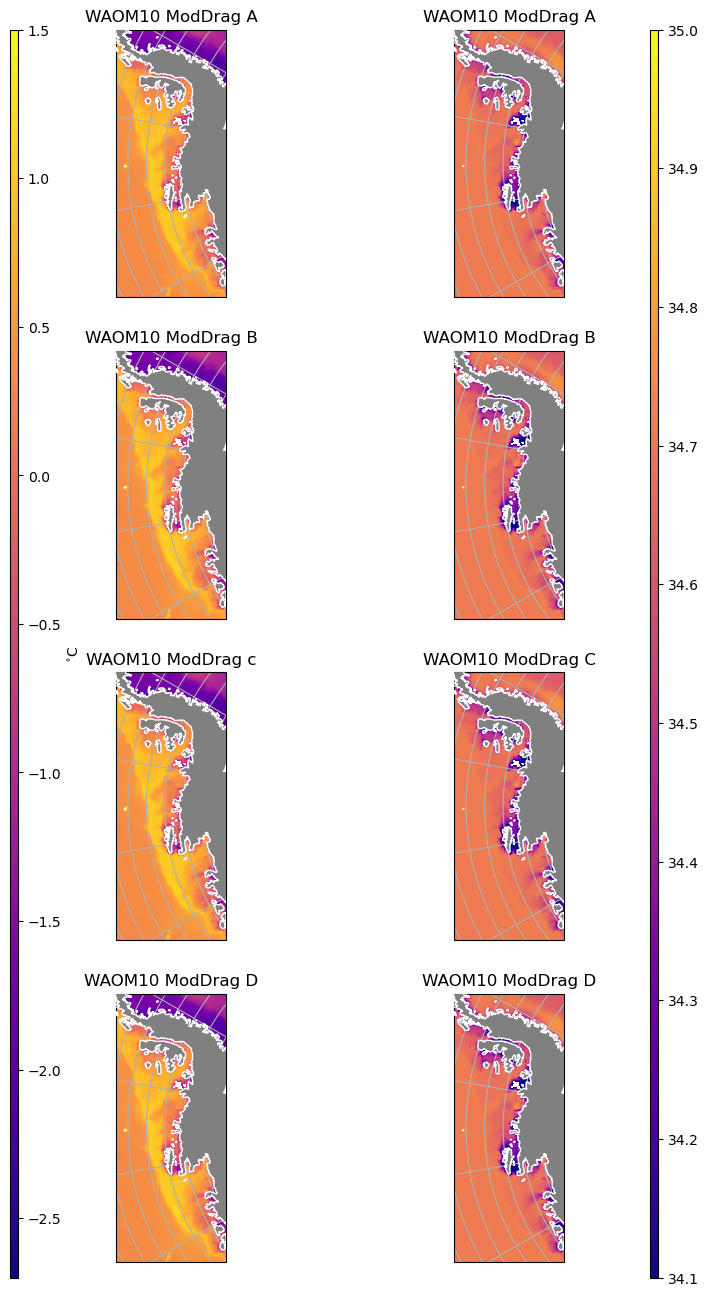

In [15]:
# call cartopy projection
proj = ccrs.SouthPolarStereo()

# ========== subregions plots:
# for 2000m isoline
bathym = cfeature.NaturalEarthFeature(name='bathymetry_J_1000', scale='10m', category='physical')
# limits for contour of ice front (Ronne-Filchner IS):
# xlimit = np.arange(300,500,1)
# ylimit = np.arange(100,300,1)

# --- bottom

tmin = -2.7
tmax = 1.5
smin = 34.1
smax = 35.

fig = plt.figure(figsize=(8,16))

ax1 = fig.add_subplot(421, projection=proj)
ct1=plt.pcolormesh(lon_rho_10km,lat_rho_10km,temp_10_mdA.isel(s_rho=0, ocean_time=range(0,12)).mean('ocean_time')*mask_shelf_10km*mask_zice_10km, transform=ccrs.PlateCarree(), cmap=plt.cm.plasma, vmin=tmin, vmax=tmax)
# plt.title('Bottom temperature \n WAOM10')
plt.title('WAOM10 ModDrag A')
ax1.set_extent([-120, -60, -68, -75], crs=ccrs.PlateCarree())
ax1.gridlines() # draw_labels=True,linewidth=
ax1.add_feature(cfeature.LAND, zorder=3, edgecolor='white', facecolor='gray')

ax2 = fig.add_subplot(422, projection=proj)
cs1=plt.pcolormesh(lon_rho_10km,lat_rho_10km,salt_10_mdA.isel(s_rho=0, ocean_time=range(0,12)).mean('ocean_time')*mask_shelf_10km*mask_zice_10km, transform=ccrs.PlateCarree(), cmap=plt.cm.plasma, vmin=smin, vmax=smax)
# plt.title('Bottom salinity \n WAOM10')
plt.title('WAOM10 ModDrag A')
ax2.set_extent([-120, -60, -68, -75], crs=ccrs.PlateCarree())
ax2.gridlines()
ax2.add_feature(cfeature.LAND, zorder=3, edgecolor='white', facecolor='gray')

ax3 = fig.add_subplot(423, projection=proj)
ct1=plt.pcolormesh(lon_rho_10km,lat_rho_10km,temp_10_mdB.isel(s_rho=0, ocean_time=range(0,12)).mean('ocean_time')*mask_shelf_10km*mask_zice_10km, transform=ccrs.PlateCarree(), cmap=plt.cm.plasma, vmin=tmin, vmax=tmax)
# plt.title('Bottom temperature \n WAOM10')
plt.title('WAOM10 ModDrag B')
ax3.set_extent([-120, -60, -68, -75], crs=ccrs.PlateCarree())
ax3.gridlines() # draw_labels=True,linewidth=
ax3.add_feature(cfeature.LAND, zorder=3, edgecolor='white', facecolor='gray')

ax4 = fig.add_subplot(424, projection=proj)
cs1=plt.pcolormesh(lon_rho_10km,lat_rho_10km,salt_10_mdB.isel(s_rho=0, ocean_time=range(0,12)).mean('ocean_time')*mask_shelf_10km*mask_zice_10km, transform=ccrs.PlateCarree(), cmap=plt.cm.plasma, vmin=smin, vmax=smax)
# plt.title('Bottom salinity \n WAOM10')
plt.title('WAOM10 ModDrag B')
ax4.set_extent([-120, -60, -68, -75], crs=ccrs.PlateCarree())
ax4.gridlines()
ax4.add_feature(cfeature.LAND, zorder=3, edgecolor='white', facecolor='gray')

ax5 = fig.add_subplot(425, projection=proj)
ct1=plt.pcolormesh(lon_rho_10km,lat_rho_10km,temp_10_mdC.isel(s_rho=0, ocean_time=range(0,12)).mean('ocean_time')*mask_shelf_10km*mask_zice_10km, transform=ccrs.PlateCarree(), cmap=plt.cm.plasma, vmin=tmin, vmax=tmax)
# plt.title('Bottom temperature \n WAOM10')
plt.title('WAOM10 ModDrag c')
ax5.set_extent([-120, -60, -68, -75], crs=ccrs.PlateCarree())
ax5.gridlines() # draw_labels=True,linewidth=
ax5.add_feature(cfeature.LAND, zorder=3, edgecolor='white', facecolor='gray')

ax6 = fig.add_subplot(426, projection=proj)
cs1=plt.pcolormesh(lon_rho_10km,lat_rho_10km,salt_10_mdC.isel(s_rho=0, ocean_time=range(0,12)).mean('ocean_time')*mask_shelf_10km*mask_zice_10km, transform=ccrs.PlateCarree(), cmap=plt.cm.plasma, vmin=smin, vmax=smax)
# plt.title('Bottom salinity \n WAOM10')
plt.title('WAOM10 ModDrag C')
ax6.set_extent([-120, -60, -68, -75], crs=ccrs.PlateCarree())
ax6.gridlines()
ax6.add_feature(cfeature.LAND, zorder=3, edgecolor='white', facecolor='gray')

ax7 = fig.add_subplot(427, projection=proj)
ct1=plt.pcolormesh(lon_rho_10km,lat_rho_10km,temp_10_mdD.isel(s_rho=0, ocean_time=range(0,12)).mean('ocean_time')*mask_shelf_10km*mask_zice_10km, transform=ccrs.PlateCarree(), cmap=plt.cm.plasma, vmin=tmin, vmax=tmax)
# plt.title('Bottom temperature \n WAOM10')
plt.title('WAOM10 ModDrag D')
ax7.set_extent([-120, -60, -68, -75], crs=ccrs.PlateCarree())
ax7.gridlines() # draw_labels=True,linewidth= 
ax7.add_feature(cfeature.LAND, zorder=3, edgecolor='white', facecolor='gray')

ax8 = fig.add_subplot(428, projection=proj)
cs1=plt.pcolormesh(lon_rho_10km,lat_rho_10km,salt_10_mdD.isel(s_rho=0, ocean_time=range(0,12)).mean('ocean_time')*mask_shelf_10km*mask_zice_10km, transform=ccrs.PlateCarree(), cmap=plt.cm.plasma, vmin=smin, vmax=smax)
# plt.title('Bottom salinity \n WAOM10')
plt.title('WAOM10 ModDrag D')
ax8.set_extent([-120, -60, -68, -75], crs=ccrs.PlateCarree())
ax8.gridlines()
ax8.add_feature(cfeature.LAND, zorder=3, edgecolor='white', facecolor='gray')

cbar_ax3 = fig.add_axes([0.1, 0.1, 0.01, 0.78])
fig.colorbar(ct1, cax=cbar_ax3, orientation='vertical')
cbar_ax3.set_ylabel('$^{\circ}$C')#, labelpad=-35)

cbar_ax4 = fig.add_axes([0.9, 0.1, 0.01, 0.78])
fig.colorbar(cs1, cax=cbar_ax4, orientation='vertical')
cbar_ax4.set_xlabel('')#, labelpad=-35)

name_fig='waom10_ModDrag_bottomTmaps_yr1.png'
plt.savefig(fig_path + name_fig, dpi=300)


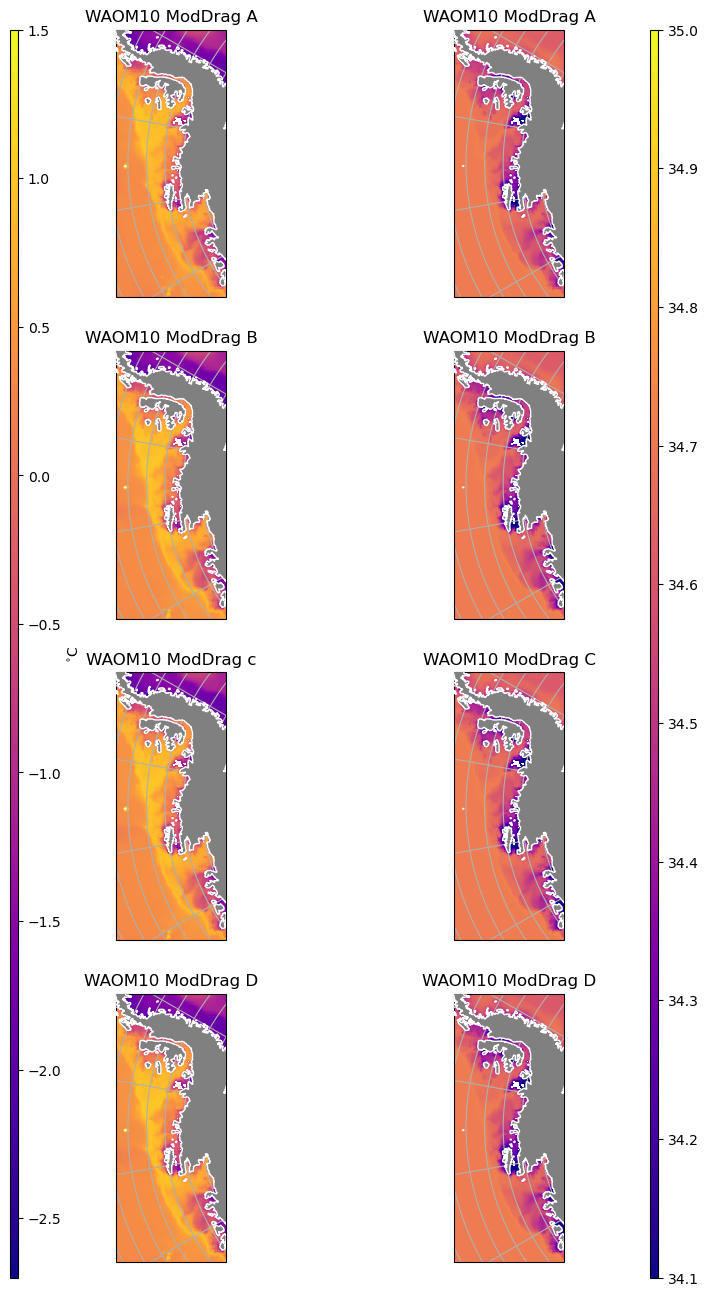

In [16]:

fig = plt.figure(figsize=(8,16))

ax1 = fig.add_subplot(421, projection=proj)
ct1=plt.pcolormesh(lon_rho_10km,lat_rho_10km,temp_10_mdA.isel(s_rho=0, ocean_time=range(12,24)).mean('ocean_time')*mask_shelf_10km*mask_zice_10km, transform=ccrs.PlateCarree(), cmap=plt.cm.plasma, vmin=tmin, vmax=tmax)
# plt.title('Bottom temperature \n WAOM10')
plt.title('WAOM10 ModDrag A')
ax1.set_extent([-120, -60, -68, -75], crs=ccrs.PlateCarree())
ax1.gridlines() # draw_labels=True,linewidth=
ax1.add_feature(cfeature.LAND, zorder=3, edgecolor='white', facecolor='gray')

ax2 = fig.add_subplot(422, projection=proj)
cs1=plt.pcolormesh(lon_rho_10km,lat_rho_10km,salt_10_mdA.isel(s_rho=0, ocean_time=range(12,24)).mean('ocean_time')*mask_shelf_10km*mask_zice_10km, transform=ccrs.PlateCarree(), cmap=plt.cm.plasma, vmin=smin, vmax=smax)
# plt.title('Bottom salinity \n WAOM10')
plt.title('WAOM10 ModDrag A')
ax2.set_extent([-120, -60, -68, -75], crs=ccrs.PlateCarree())
ax2.gridlines()
ax2.add_feature(cfeature.LAND, zorder=3, edgecolor='white', facecolor='gray')

ax3 = fig.add_subplot(423, projection=proj)
ct1=plt.pcolormesh(lon_rho_10km,lat_rho_10km,temp_10_mdB.isel(s_rho=0, ocean_time=range(12,24)).mean('ocean_time')*mask_shelf_10km*mask_zice_10km, transform=ccrs.PlateCarree(), cmap=plt.cm.plasma, vmin=tmin, vmax=tmax)
# plt.title('Bottom temperature \n WAOM10')
plt.title('WAOM10 ModDrag B')
ax3.set_extent([-120, -60, -68, -75], crs=ccrs.PlateCarree())
ax3.gridlines() # draw_labels=True,linewidth=
ax3.add_feature(cfeature.LAND, zorder=3, edgecolor='white', facecolor='gray')

ax4 = fig.add_subplot(424, projection=proj)
cs1=plt.pcolormesh(lon_rho_10km,lat_rho_10km,salt_10_mdB.isel(s_rho=0, ocean_time=range(12,24)).mean('ocean_time')*mask_shelf_10km*mask_zice_10km, transform=ccrs.PlateCarree(), cmap=plt.cm.plasma, vmin=smin, vmax=smax)
# plt.title('Bottom salinity \n WAOM10')
plt.title('WAOM10 ModDrag B')
ax4.set_extent([-120, -60, -68, -75], crs=ccrs.PlateCarree())
ax4.gridlines()
ax4.add_feature(cfeature.LAND, zorder=3, edgecolor='white', facecolor='gray')

ax5 = fig.add_subplot(425, projection=proj)
ct1=plt.pcolormesh(lon_rho_10km,lat_rho_10km,temp_10_mdC.isel(s_rho=0, ocean_time=range(12,24)).mean('ocean_time')*mask_shelf_10km*mask_zice_10km, transform=ccrs.PlateCarree(), cmap=plt.cm.plasma, vmin=tmin, vmax=tmax)
# plt.title('Bottom temperature \n WAOM10')
plt.title('WAOM10 ModDrag c')
ax5.set_extent([-120, -60, -68, -75], crs=ccrs.PlateCarree())
ax5.gridlines() # draw_labels=True,linewidth=
ax5.add_feature(cfeature.LAND, zorder=3, edgecolor='white', facecolor='gray')

ax6 = fig.add_subplot(426, projection=proj)
cs1=plt.pcolormesh(lon_rho_10km,lat_rho_10km,salt_10_mdC.isel(s_rho=0, ocean_time=range(12,24)).mean('ocean_time')*mask_shelf_10km*mask_zice_10km, transform=ccrs.PlateCarree(), cmap=plt.cm.plasma, vmin=smin, vmax=smax)
# plt.title('Bottom salinity \n WAOM10')
plt.title('WAOM10 ModDrag C')
ax6.set_extent([-120, -60, -68, -75], crs=ccrs.PlateCarree())
ax6.gridlines()
ax6.add_feature(cfeature.LAND, zorder=3, edgecolor='white', facecolor='gray')

ax7 = fig.add_subplot(427, projection=proj)
ct1=plt.pcolormesh(lon_rho_10km,lat_rho_10km,temp_10_mdD.isel(s_rho=0, ocean_time=range(12,24)).mean('ocean_time')*mask_shelf_10km*mask_zice_10km, transform=ccrs.PlateCarree(), cmap=plt.cm.plasma, vmin=tmin, vmax=tmax)
# plt.title('Bottom temperature \n WAOM10')
plt.title('WAOM10 ModDrag D')
ax7.set_extent([-120, -60, -68, -75], crs=ccrs.PlateCarree())
ax7.gridlines() # draw_labels=True,linewidth= 
ax7.add_feature(cfeature.LAND, zorder=3, edgecolor='white', facecolor='gray')

ax8 = fig.add_subplot(428, projection=proj)
cs1=plt.pcolormesh(lon_rho_10km,lat_rho_10km,salt_10_mdD.isel(s_rho=0, ocean_time=range(12,24)).mean('ocean_time')*mask_shelf_10km*mask_zice_10km, transform=ccrs.PlateCarree(), cmap=plt.cm.plasma, vmin=smin, vmax=smax)
# plt.title('Bottom salinity \n WAOM10')
plt.title('WAOM10 ModDrag D')
ax8.set_extent([-120, -60, -68, -75], crs=ccrs.PlateCarree())
ax8.gridlines()
ax8.add_feature(cfeature.LAND, zorder=3, edgecolor='white', facecolor='gray')

cbar_ax3 = fig.add_axes([0.1, 0.1, 0.01, 0.78])
fig.colorbar(ct1, cax=cbar_ax3, orientation='vertical')
cbar_ax3.set_ylabel('$^{\circ}$C')#, labelpad=-35)

cbar_ax4 = fig.add_axes([0.9, 0.1, 0.01, 0.78])
fig.colorbar(cs1, cax=cbar_ax4, orientation='vertical')
cbar_ax4.set_xlabel('')#, labelpad=-35)

name_fig='waom10_ModDrag_bottomTmaps_yr2.png'
plt.savefig(fig_path + name_fig, dpi=300)


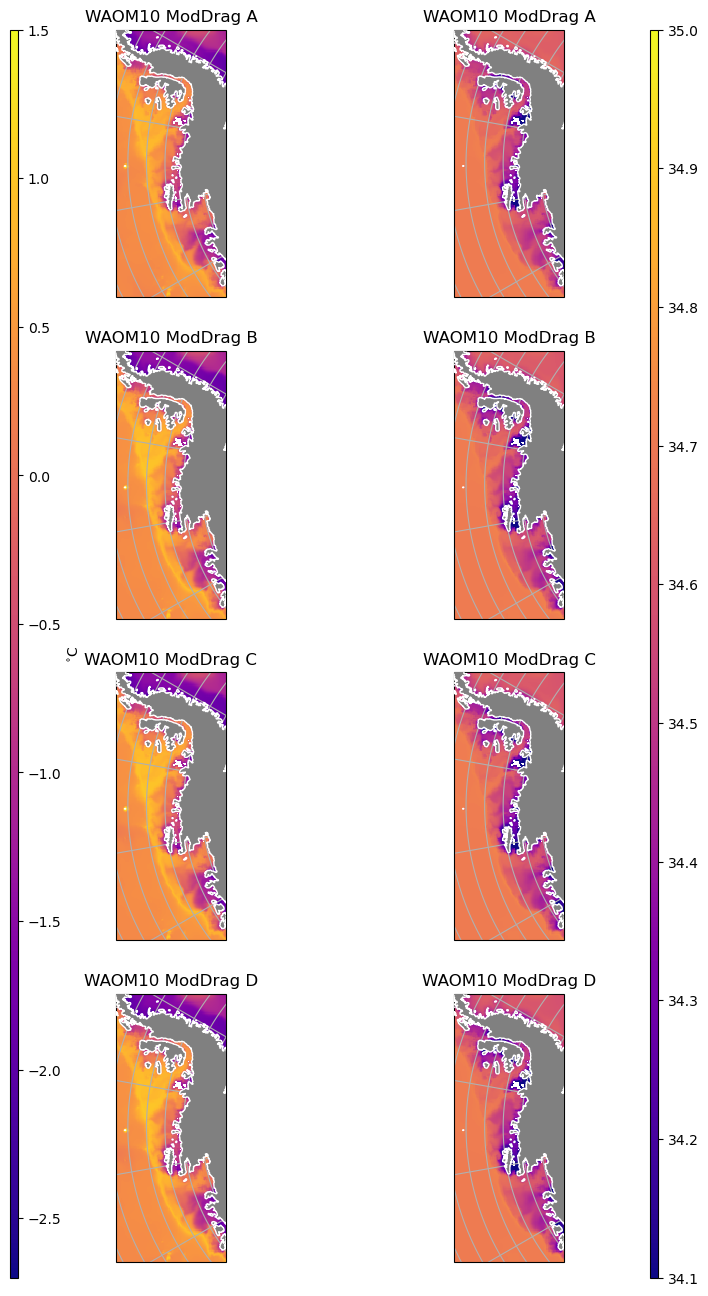

In [17]:
# call cartopy projection
proj = ccrs.SouthPolarStereo()

# ========== subregions plots:
# for 2000m isoline
bathym = cfeature.NaturalEarthFeature(name='bathymetry_J_1000', scale='10m', category='physical')
# limits for contour of ice front (Ronne-Filchner IS):
# xlimit = np.arange(300,500,1)
# ylimit = np.arange(100,300,1)

# --- bottom

tmin = -2.7
tmax = 1.5
smin = 34.1
smax = 35.

fig = plt.figure(figsize=(8,16))

ax1 = fig.add_subplot(421, projection=proj)
ct1=plt.pcolormesh(lon_rho_10km,lat_rho_10km,temp_10_mdA.isel(s_rho=0, ocean_time=range(24,36)).mean('ocean_time')*mask_shelf_10km*mask_zice_10km, transform=ccrs.PlateCarree(), cmap=plt.cm.plasma, vmin=tmin, vmax=tmax)
# plt.title('Bottom temperature \n WAOM10')
plt.title('WAOM10 ModDrag A')
ax1.set_extent([-120, -60, -68, -75], crs=ccrs.PlateCarree())
ax1.gridlines() # draw_labels=True,linewidth=
ax1.add_feature(cfeature.LAND, zorder=3, edgecolor='white', facecolor='gray')

ax2 = fig.add_subplot(422, projection=proj)
cs1=plt.pcolormesh(lon_rho_10km,lat_rho_10km,salt_10_mdA.isel(s_rho=0, ocean_time=range(24,36)).mean('ocean_time')*mask_shelf_10km*mask_zice_10km, transform=ccrs.PlateCarree(), cmap=plt.cm.plasma, vmin=smin, vmax=smax)
# plt.title('Bottom salinity \n WAOM10')
plt.title('WAOM10 ModDrag A')
ax2.set_extent([-120, -60, -68, -75], crs=ccrs.PlateCarree())
ax2.gridlines()
ax2.add_feature(cfeature.LAND, zorder=3, edgecolor='white', facecolor='gray')

ax3 = fig.add_subplot(423, projection=proj)
ct1=plt.pcolormesh(lon_rho_10km,lat_rho_10km,temp_10_mdB.isel(s_rho=0, ocean_time=range(24,36)).mean('ocean_time')*mask_shelf_10km*mask_zice_10km, transform=ccrs.PlateCarree(), cmap=plt.cm.plasma, vmin=tmin, vmax=tmax)
# plt.title('Bottom temperature \n WAOM10')
plt.title('WAOM10 ModDrag B')
ax3.set_extent([-120, -60, -68, -75], crs=ccrs.PlateCarree())
ax3.gridlines() # draw_labels=True,linewidth=
ax3.add_feature(cfeature.LAND, zorder=3, edgecolor='white', facecolor='gray')

ax4 = fig.add_subplot(424, projection=proj)
cs1=plt.pcolormesh(lon_rho_10km,lat_rho_10km,salt_10_mdB.isel(s_rho=0, ocean_time=range(24,36)).mean('ocean_time')*mask_shelf_10km*mask_zice_10km, transform=ccrs.PlateCarree(), cmap=plt.cm.plasma, vmin=smin, vmax=smax)
# plt.title('Bottom salinity \n WAOM10')
plt.title('WAOM10 ModDrag B')
ax4.set_extent([-120, -60, -68, -75], crs=ccrs.PlateCarree())
ax4.gridlines()
ax4.add_feature(cfeature.LAND, zorder=3, edgecolor='white', facecolor='gray')

ax5 = fig.add_subplot(425, projection=proj)
ct1=plt.pcolormesh(lon_rho_10km,lat_rho_10km,temp_10_mdC.isel(s_rho=0, ocean_time=range(24,36)).mean('ocean_time')*mask_shelf_10km*mask_zice_10km, transform=ccrs.PlateCarree(), cmap=plt.cm.plasma, vmin=tmin, vmax=tmax)
# plt.title('Bottom temperature \n WAOM10')
plt.title('WAOM10 ModDrag C')
ax5.set_extent([-120, -60, -68, -75], crs=ccrs.PlateCarree())
ax5.gridlines() # draw_labels=True,linewidth=
ax5.add_feature(cfeature.LAND, zorder=3, edgecolor='white', facecolor='gray')

ax6 = fig.add_subplot(426, projection=proj)
cs1=plt.pcolormesh(lon_rho_10km,lat_rho_10km,salt_10_mdC.isel(s_rho=0, ocean_time=range(24,36)).mean('ocean_time')*mask_shelf_10km*mask_zice_10km, transform=ccrs.PlateCarree(), cmap=plt.cm.plasma, vmin=smin, vmax=smax)
# plt.title('Bottom salinity \n WAOM10')
plt.title('WAOM10 ModDrag C')
ax6.set_extent([-120, -60, -68, -75], crs=ccrs.PlateCarree())
ax6.gridlines()
ax6.add_feature(cfeature.LAND, zorder=3, edgecolor='white', facecolor='gray')

ax7 = fig.add_subplot(427, projection=proj)
ct1=plt.pcolormesh(lon_rho_10km,lat_rho_10km,temp_10_mdD.isel(s_rho=0, ocean_time=range(24,36)).mean('ocean_time')*mask_shelf_10km*mask_zice_10km, transform=ccrs.PlateCarree(), cmap=plt.cm.plasma, vmin=tmin, vmax=tmax)
# plt.title('Bottom temperature \n WAOM10')
plt.title('WAOM10 ModDrag D')
ax7.set_extent([-120, -60, -68, -75], crs=ccrs.PlateCarree())
ax7.gridlines() # draw_labels=True,linewidth= 
ax7.add_feature(cfeature.LAND, zorder=3, edgecolor='white', facecolor='gray')

ax8 = fig.add_subplot(428, projection=proj)
cs1=plt.pcolormesh(lon_rho_10km,lat_rho_10km,salt_10_mdD.isel(s_rho=0, ocean_time=range(24,36)).mean('ocean_time')*mask_shelf_10km*mask_zice_10km, transform=ccrs.PlateCarree(), cmap=plt.cm.plasma, vmin=smin, vmax=smax)
# plt.title('Bottom salinity \n WAOM10')
plt.title('WAOM10 ModDrag D')
ax8.set_extent([-120, -60, -68, -75], crs=ccrs.PlateCarree())
ax8.gridlines()
ax8.add_feature(cfeature.LAND, zorder=3, edgecolor='white', facecolor='gray')

cbar_ax3 = fig.add_axes([0.1, 0.1, 0.01, 0.78])
fig.colorbar(ct1, cax=cbar_ax3, orientation='vertical')
cbar_ax3.set_ylabel('$^{\circ}$C')#, labelpad=-35)

cbar_ax4 = fig.add_axes([0.9, 0.1, 0.01, 0.78])
fig.colorbar(cs1, cax=cbar_ax4, orientation='vertical')
cbar_ax4.set_xlabel('')#, labelpad=-35)

name_fig='waom10_ModDrag_bottomTmaps_yr3.png'
plt.savefig(fig_path + name_fig, dpi=300)


## plots for annual average bottom temp/salt for waom10e vs waom4e with ModDragD for years 1-3:

CPU times: user 29.1 s, sys: 2.68 s, total: 31.8 s
Wall time: 1min 13s


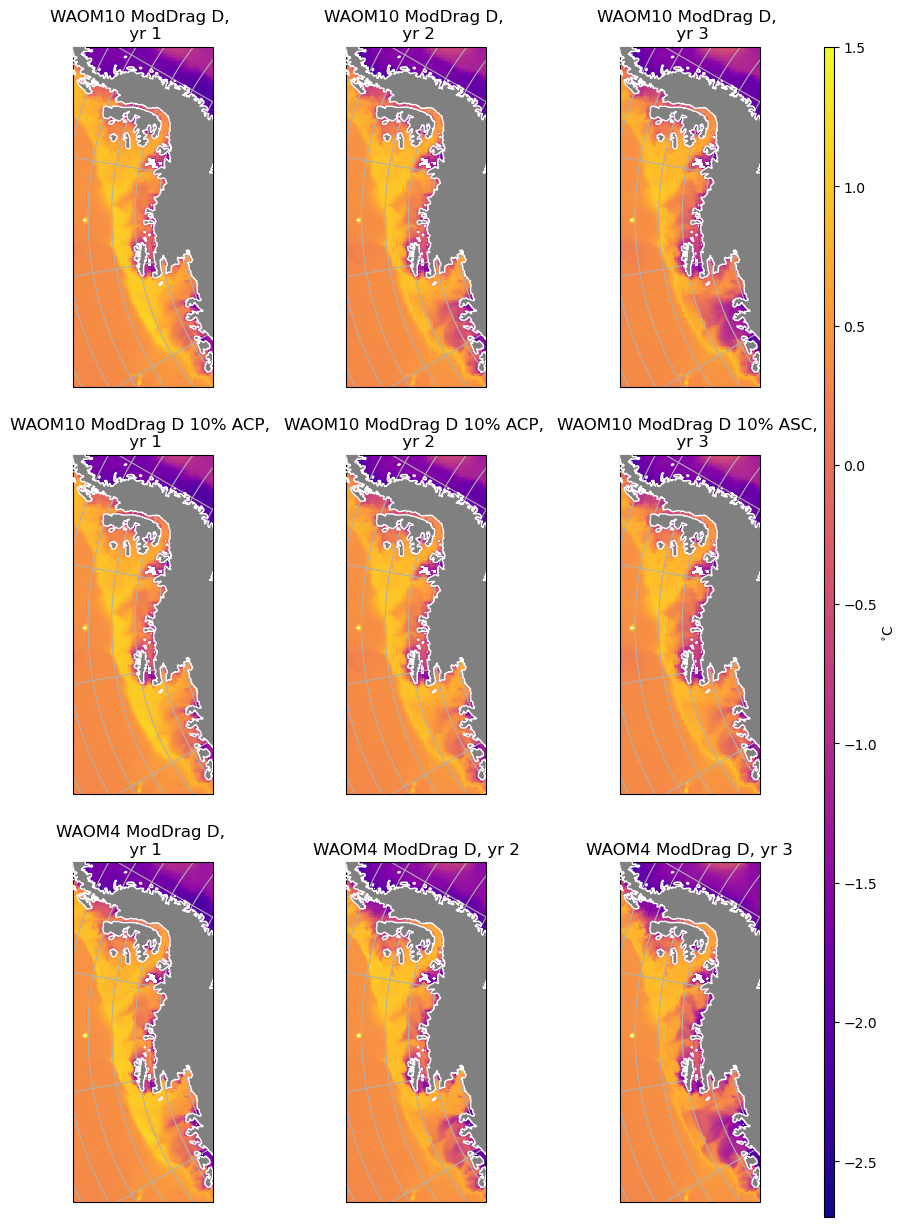

In [18]:
%%time
# call cartopy projection
proj = ccrs.SouthPolarStereo()

# ========== subregions plots:
# for 2000m isoline
# bathym = cfeature.NaturalEarthFeature(name='bathymetry_J_1000', scale='10m', category='physical')
# limits for contour of ice front (Ronne-Filchner IS):
# xlimit = np.arange(300,500,1)
# ylimit = np.arange(100,300,1)

# --- bottom

tmin = -2.7
tmax = 1.5
smin = 34.1
smax = 34.84

fig = plt.figure(figsize=(10,15))

ax1 = fig.add_subplot(331, projection=proj)
ct1=plt.pcolormesh(lon_rho_10km,lat_rho_10km,temp_10_mdD.isel(s_rho=0, ocean_time=range(0,12)).mean('ocean_time')*mask_shelf_10km*mask_zice_10km, transform=ccrs.PlateCarree(), cmap=plt.cm.plasma, vmin=tmin, vmax=tmax)
plt.title('WAOM10 ModDrag D, \n yr 1')
ax1.set_extent([-120, -60, -68, -75], crs=ccrs.PlateCarree())
ax1.gridlines() # draw_labels=True,linewidth=
ax1.add_feature(cfeature.LAND, zorder=3, edgecolor='white', facecolor='gray')

ax2 = fig.add_subplot(332, projection=proj)
ct1=plt.pcolormesh(lon_rho_10km,lat_rho_10km,temp_10_mdD.isel(s_rho=0, ocean_time=range(12,24)).mean('ocean_time')*mask_shelf_10km*mask_zice_10km, transform=ccrs.PlateCarree(), cmap=plt.cm.plasma, vmin=tmin, vmax=tmax)
plt.title('WAOM10 ModDrag D, \n yr 2')
ax2.set_extent([-120, -60, -68, -75], crs=ccrs.PlateCarree())
ax2.gridlines()
ax2.add_feature(cfeature.LAND, zorder=3, edgecolor='white', facecolor='gray')

ax3 = fig.add_subplot(333, projection=proj)
ct1=plt.pcolormesh(lon_rho_10km,lat_rho_10km,temp_10_mdD.isel(s_rho=0, ocean_time=range(24,36)).mean('ocean_time')*mask_shelf_10km*mask_zice_10km, transform=ccrs.PlateCarree(), cmap=plt.cm.plasma, vmin=tmin, vmax=tmax)
plt.title('WAOM10 ModDrag D, \n yr 3')
ax3.set_extent([-120, -60, -68, -75], crs=ccrs.PlateCarree())
ax3.gridlines() # draw_labels=True,linewidth=
ax3.add_feature(cfeature.LAND, zorder=3, edgecolor='white', facecolor='gray')

ax4 = fig.add_subplot(334, projection=proj)
ct1=plt.pcolormesh(lon_rho_10km,lat_rho_10km,temp_10_mdD_ACP.isel(s_rho=0, ocean_time=range(0,12)).mean('ocean_time')*mask_shelf_10km*mask_zice_10km, transform=ccrs.PlateCarree(), cmap=plt.cm.plasma, vmin=tmin, vmax=tmax)
plt.title('WAOM10 ModDrag D 10% ACP, \n yr 1')
ax4.set_extent([-120, -60, -68, -75], crs=ccrs.PlateCarree())
ax4.gridlines()
ax4.add_feature(cfeature.LAND, zorder=3, edgecolor='white', facecolor='gray')

ax5 = fig.add_subplot(335, projection=proj)
ct1=plt.pcolormesh(lon_rho_10km,lat_rho_10km,temp_10_mdD_ACP.isel(s_rho=0, ocean_time=range(12,24)).mean('ocean_time')*mask_shelf_10km*mask_zice_10km, transform=ccrs.PlateCarree(), cmap=plt.cm.plasma, vmin=tmin, vmax=tmax)
plt.title('WAOM10 ModDrag D 10% ACP, \n yr 2')
ax5.set_extent([-120, -60, -68, -75], crs=ccrs.PlateCarree())
ax5.gridlines() # draw_labels=True,linewidth=
ax5.add_feature(cfeature.LAND, zorder=3, edgecolor='white', facecolor='gray')

ax6 = fig.add_subplot(336, projection=proj)
ct1=plt.pcolormesh(lon_rho_10km,lat_rho_10km,temp_10_mdD_ACP.isel(s_rho=0, ocean_time=range(24,36)).mean('ocean_time')*mask_shelf_10km*mask_zice_10km, transform=ccrs.PlateCarree(), cmap=plt.cm.plasma, vmin=tmin, vmax=tmax)
plt.title('WAOM10 ModDrag D 10% ASC, \n yr 3')
ax6.set_extent([-120, -60, -68, -75], crs=ccrs.PlateCarree())
ax6.gridlines()
ax6.add_feature(cfeature.LAND, zorder=3, edgecolor='white', facecolor='gray')

ax7 = fig.add_subplot(337, projection=proj)
ct1=plt.pcolormesh(lon_rho_4km,lat_rho_4km,temp_4_mdD.isel(s_rho=0, ocean_time=range(0,12)).mean('ocean_time')*mask_shelf_4km*mask_zice_4km, transform=ccrs.PlateCarree(), cmap=plt.cm.plasma, vmin=tmin, vmax=tmax)
plt.title('WAOM4 ModDrag D, \n yr 1')
ax7.set_extent([-120, -60, -68, -75], crs=ccrs.PlateCarree())
ax7.gridlines()
ax7.add_feature(cfeature.LAND, zorder=3, edgecolor='white', facecolor='gray')

ax8 = fig.add_subplot(338, projection=proj)
ct1=plt.pcolormesh(lon_rho_4km,lat_rho_4km,temp_4_mdD.isel(s_rho=0, ocean_time=range(12,24)).mean('ocean_time')*mask_shelf_4km*mask_zice_4km, transform=ccrs.PlateCarree(), cmap=plt.cm.plasma, vmin=tmin, vmax=tmax)
plt.title('WAOM4 ModDrag D, yr 2')
ax8.set_extent([-120, -60, -68, -75], crs=ccrs.PlateCarree())
ax8.gridlines() # draw_labels=True,linewidth=
ax8.add_feature(cfeature.LAND, zorder=3, edgecolor='white', facecolor='gray')

ax9 = fig.add_subplot(339, projection=proj)
ct1=plt.pcolormesh(lon_rho_4km,lat_rho_4km,temp_4_mdD.isel(s_rho=0, ocean_time=range(24,36)).mean('ocean_time')*mask_shelf_4km*mask_zice_4km, transform=ccrs.PlateCarree(), cmap=plt.cm.plasma, vmin=tmin, vmax=tmax)
plt.title('WAOM4 ModDrag D, yr 3')
ax9.set_extent([-120, -60, -68, -75], crs=ccrs.PlateCarree())
ax9.gridlines()
ax9.add_feature(cfeature.LAND, zorder=3, edgecolor='white', facecolor='gray')

cbar_ax3 = fig.add_axes([0.92, 0.1, 0.01, 0.78])
fig.colorbar(ct1, cax=cbar_ax3, orientation='vertical')
cbar_ax3.set_ylabel('$^{\circ}$C')#, labelpad=-35)

# cbar_ax4 = fig.add_axes([0.92, 0.05, 0.01, 0.8])
# fig.colorbar(cs1, cax=cbar_ax4, orientation='vertical')
# cbar_ax4.set_xlabel('')#, labelpad=-35)

name_fig='waom10x4e_ModDrag_bottomTmaps_yr1-3.png'
plt.savefig(fig_path + name_fig, dpi=300)


CPU times: user 29.2 s, sys: 2.49 s, total: 31.7 s
Wall time: 1min 7s


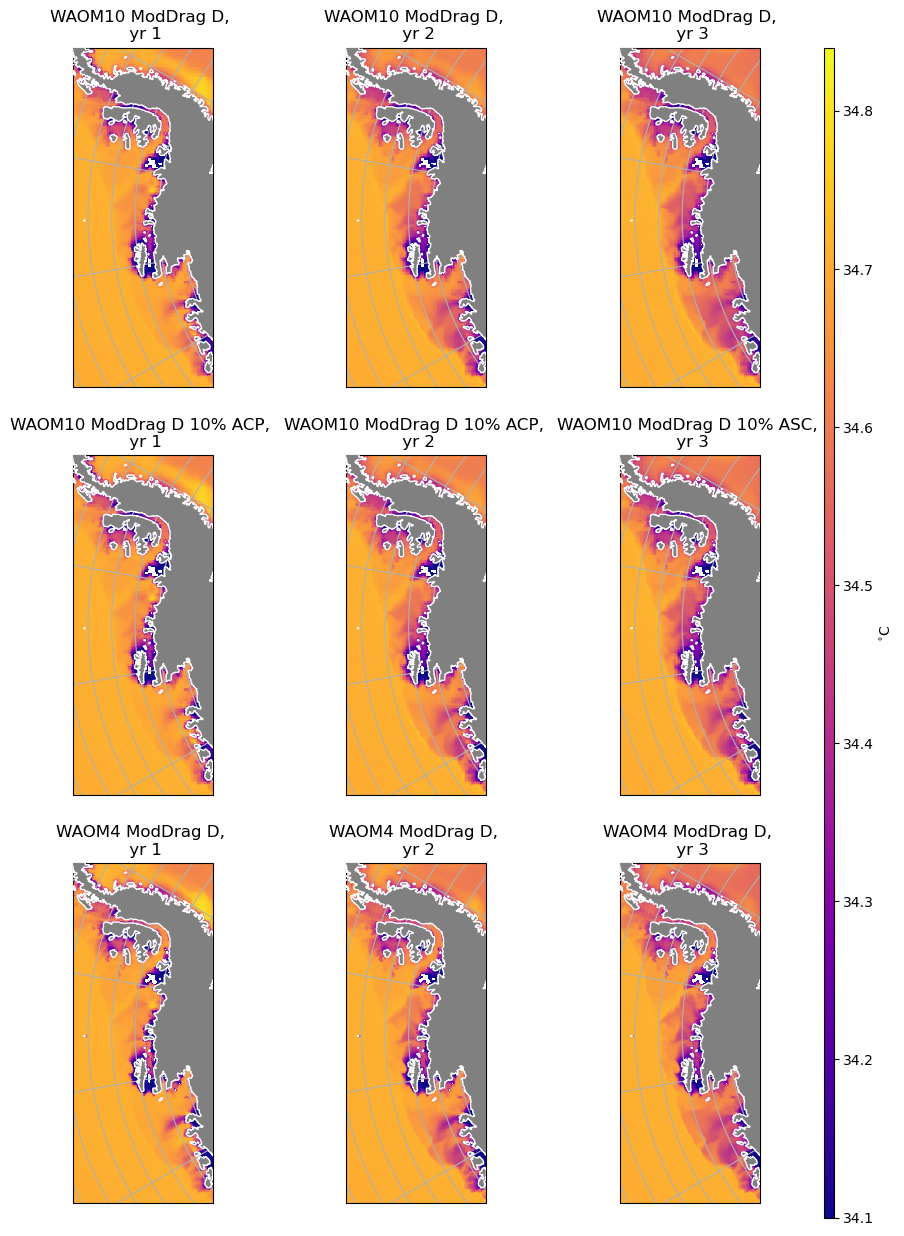

In [19]:
%%time
# --- bottom

smin = 34.1
smax = 34.84

fig = plt.figure(figsize=(10,15))

ax1 = fig.add_subplot(331, projection=proj)
ct1=plt.pcolormesh(lon_rho_10km,lat_rho_10km,salt_10_mdD.isel(s_rho=0, ocean_time=range(0,12)).mean('ocean_time')*mask_shelf_10km*mask_zice_10km, transform=ccrs.PlateCarree(), cmap=plt.cm.plasma, vmin=smin, vmax=smax)
plt.title('WAOM10 ModDrag D, \n yr 1')
ax1.set_extent([-120, -60, -68, -75], crs=ccrs.PlateCarree())
ax1.gridlines() # draw_labels=True,linewidth=
ax1.add_feature(cfeature.LAND, zorder=3, edgecolor='white', facecolor='gray')

ax2 = fig.add_subplot(332, projection=proj)
ct1=plt.pcolormesh(lon_rho_10km,lat_rho_10km,salt_10_mdD.isel(s_rho=0, ocean_time=range(12,24)).mean('ocean_time')*mask_shelf_10km*mask_zice_10km, transform=ccrs.PlateCarree(), cmap=plt.cm.plasma, vmin=smin, vmax=smax)
plt.title('WAOM10 ModDrag D, \n yr 2')
ax2.set_extent([-120, -60, -68, -75], crs=ccrs.PlateCarree())
ax2.gridlines()
ax2.add_feature(cfeature.LAND, zorder=3, edgecolor='white', facecolor='gray')

ax3 = fig.add_subplot(333, projection=proj)
ct1=plt.pcolormesh(lon_rho_10km,lat_rho_10km,salt_10_mdD.isel(s_rho=0, ocean_time=range(24,36)).mean('ocean_time')*mask_shelf_10km*mask_zice_10km, transform=ccrs.PlateCarree(), cmap=plt.cm.plasma, vmin=smin, vmax=smax)
plt.title('WAOM10 ModDrag D, \n yr 3')
ax3.set_extent([-120, -60, -68, -75], crs=ccrs.PlateCarree())
ax3.gridlines() # draw_labels=True,linewidth=
ax3.add_feature(cfeature.LAND, zorder=3, edgecolor='white', facecolor='gray')

ax4 = fig.add_subplot(334, projection=proj)
ct1=plt.pcolormesh(lon_rho_10km,lat_rho_10km,salt_10_mdD_ACP.isel(s_rho=0, ocean_time=range(0,12)).mean('ocean_time')*mask_shelf_10km*mask_zice_10km, transform=ccrs.PlateCarree(), cmap=plt.cm.plasma, vmin=smin, vmax=smax)
plt.title('WAOM10 ModDrag D 10% ACP, \n yr 1')
ax4.set_extent([-120, -60, -68, -75], crs=ccrs.PlateCarree())
ax4.gridlines()
ax4.add_feature(cfeature.LAND, zorder=3, edgecolor='white', facecolor='gray')

ax5 = fig.add_subplot(335, projection=proj)
ct1=plt.pcolormesh(lon_rho_10km,lat_rho_10km,salt_10_mdD_ACP.isel(s_rho=0, ocean_time=range(12,24)).mean('ocean_time')*mask_shelf_10km*mask_zice_10km, transform=ccrs.PlateCarree(), cmap=plt.cm.plasma, vmin=smin, vmax=smax)
plt.title('WAOM10 ModDrag D 10% ACP, \n yr 2')
ax5.set_extent([-120, -60, -68, -75], crs=ccrs.PlateCarree())
ax5.gridlines() # draw_labels=True,linewidth=
ax5.add_feature(cfeature.LAND, zorder=3, edgecolor='white', facecolor='gray')

ax6 = fig.add_subplot(336, projection=proj)
ct1=plt.pcolormesh(lon_rho_10km,lat_rho_10km,salt_10_mdD_ACP.isel(s_rho=0, ocean_time=range(24,36)).mean('ocean_time')*mask_shelf_10km*mask_zice_10km, transform=ccrs.PlateCarree(), cmap=plt.cm.plasma, vmin=smin, vmax=smax)
plt.title('WAOM10 ModDrag D 10% ASC, \n yr 3')
ax6.set_extent([-120, -60, -68, -75], crs=ccrs.PlateCarree())
ax6.gridlines()
ax6.add_feature(cfeature.LAND, zorder=3, edgecolor='white', facecolor='gray')

ax7 = fig.add_subplot(337, projection=proj)
ct1=plt.pcolormesh(lon_rho_4km,lat_rho_4km,salt_4_mdD.isel(s_rho=0, ocean_time=range(0,12)).mean('ocean_time')*mask_shelf_4km*mask_zice_4km, transform=ccrs.PlateCarree(), cmap=plt.cm.plasma, vmin=smin, vmax=smax)
plt.title('WAOM4 ModDrag D, \n yr 1')
ax7.set_extent([-120, -60, -68, -75], crs=ccrs.PlateCarree())
ax7.gridlines()
ax7.add_feature(cfeature.LAND, zorder=3, edgecolor='white', facecolor='gray')

ax8 = fig.add_subplot(338, projection=proj)
ct1=plt.pcolormesh(lon_rho_4km,lat_rho_4km,salt_4_mdD.isel(s_rho=0, ocean_time=range(12,24)).mean('ocean_time')*mask_shelf_4km*mask_zice_4km, transform=ccrs.PlateCarree(), cmap=plt.cm.plasma, vmin=smin, vmax=smax)
plt.title('WAOM4 ModDrag D, \n yr 2')
ax8.set_extent([-120, -60, -68, -75], crs=ccrs.PlateCarree())
ax8.gridlines() # draw_labels=True,linewidth=
ax8.add_feature(cfeature.LAND, zorder=3, edgecolor='white', facecolor='gray')

ax9 = fig.add_subplot(339, projection=proj)
ct1=plt.pcolormesh(lon_rho_4km,lat_rho_4km,salt_4_mdD.isel(s_rho=0, ocean_time=range(24,36)).mean('ocean_time')*mask_shelf_4km*mask_zice_4km, transform=ccrs.PlateCarree(), cmap=plt.cm.plasma, vmin=smin, vmax=smax)
plt.title('WAOM4 ModDrag D, \n yr 3')
ax9.set_extent([-120, -60, -68, -75], crs=ccrs.PlateCarree())
ax9.gridlines()
ax9.add_feature(cfeature.LAND, zorder=3, edgecolor='white', facecolor='gray')

cbar_ax3 = fig.add_axes([0.92, 0.1, 0.01, 0.78])
fig.colorbar(ct1, cax=cbar_ax3, orientation='vertical')
cbar_ax3.set_ylabel('$^{\circ}$C')#, labelpad=-35)

# cbar_ax4 = fig.add_axes([0.92, 0.05, 0.01, 0.8])
# fig.colorbar(cs1, cax=cbar_ax4, orientation='vertical')
# cbar_ax4.set_xlabel('')#, labelpad=-35)

name_fig='waom10x4e_ModDrag_bottomSmaps_yr1-3.png'
plt.savefig(fig_path + name_fig, dpi=300)


## plots for annual average surface height elevation for waom10e vs waom4e with ModDragD for years 1-3:

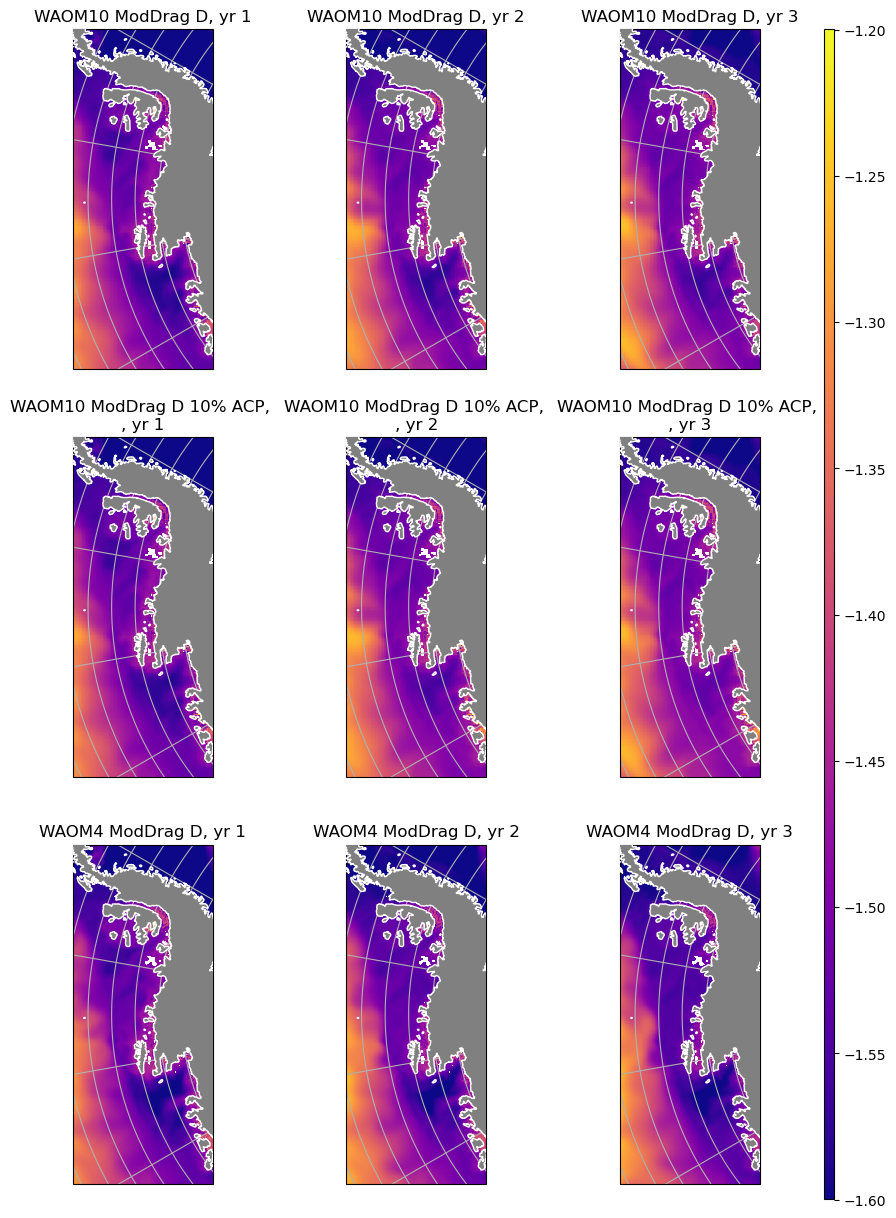

In [20]:
# call cartopy projection
proj = ccrs.SouthPolarStereo()

xmin=-1.6
xmax=-1.2

fig = plt.figure(figsize=(10,15))

ax1 = fig.add_subplot(331, projection=proj)
cs1=plt.pcolormesh(lon_rho_10km,lat_rho_10km,zeta_10_mdD.isel(ocean_time=range(0,12)).mean('ocean_time')*mask_shelf_10km*mask_zice_10km, transform=ccrs.PlateCarree(), cmap=plt.cm.plasma, vmin=xmin, vmax=xmax)
plt.title('WAOM10 ModDrag D, yr 1')
ax1.set_extent([-120, -60, -68, -75], crs=ccrs.PlateCarree())
ax1.gridlines() # draw_labels=True,linewidth=
ax1.add_feature(cfeature.LAND, zorder=3, edgecolor='white', facecolor='gray')

ax2 = fig.add_subplot(332, projection=proj)
cs1=plt.pcolormesh(lon_rho_10km,lat_rho_10km,zeta_10_mdD.isel(ocean_time=range(12,24)).mean('ocean_time')*mask_shelf_10km*mask_zice_10km, transform=ccrs.PlateCarree(), cmap=plt.cm.plasma, vmin=xmin, vmax=xmax)
plt.title('WAOM10 ModDrag D, yr 2')
ax2.set_extent([-120, -60, -68, -75], crs=ccrs.PlateCarree())
ax2.gridlines()
ax2.add_feature(cfeature.LAND, zorder=3, edgecolor='white', facecolor='gray')

ax3 = fig.add_subplot(333, projection=proj)
cs1=plt.pcolormesh(lon_rho_10km,lat_rho_10km,zeta_10_mdD.isel(ocean_time=range(24,36)).mean('ocean_time')*mask_shelf_10km*mask_zice_10km, transform=ccrs.PlateCarree(), cmap=plt.cm.plasma, vmin=xmin, vmax=xmax)
plt.title('WAOM10 ModDrag D, yr 3')
ax3.set_extent([-120, -60, -68, -75], crs=ccrs.PlateCarree())
ax3.gridlines() # draw_labels=True,linewidth=
ax3.add_feature(cfeature.LAND, zorder=3, edgecolor='white', facecolor='gray')

ax3 = fig.add_subplot(334, projection=proj)
cs1=plt.pcolormesh(lon_rho_10km,lat_rho_10km,zeta_10_mdD_ACP.isel(ocean_time=range(0,12)).mean('ocean_time')*mask_shelf_10km*mask_zice_10km, transform=ccrs.PlateCarree(), cmap=plt.cm.plasma, vmin=xmin, vmax=xmax)
plt.title('WAOM10 ModDrag D 10% ACP, \n, yr 1')
ax3.set_extent([-120, -60, -68, -75], crs=ccrs.PlateCarree())
ax3.gridlines() # draw_labels=True,linewidth=
ax3.add_feature(cfeature.LAND, zorder=3, edgecolor='white', facecolor='gray')

ax4 = fig.add_subplot(335, projection=proj)
cs1=plt.pcolormesh(lon_rho_10km,lat_rho_10km,zeta_10_mdD_ACP.isel(ocean_time=range(12,24)).mean('ocean_time')*mask_shelf_10km*mask_zice_10km, transform=ccrs.PlateCarree(), cmap=plt.cm.plasma, vmin=xmin, vmax=xmax)
plt.title('WAOM10 ModDrag D 10% ACP, \n, yr 2')
ax4.set_extent([-120, -60, -68, -75], crs=ccrs.PlateCarree())
ax4.gridlines()
ax4.add_feature(cfeature.LAND, zorder=3, edgecolor='white', facecolor='gray')

ax5 = fig.add_subplot(336, projection=proj)
cs1=plt.pcolormesh(lon_rho_10km,lat_rho_10km,zeta_10_mdD_ACP.isel(ocean_time=range(24,36)).mean('ocean_time')*mask_shelf_10km*mask_zice_10km, transform=ccrs.PlateCarree(), cmap=plt.cm.plasma, vmin=xmin, vmax=xmax)
plt.title('WAOM10 ModDrag D 10% ACP, \n, yr 3')
ax5.set_extent([-120, -60, -68, -75], crs=ccrs.PlateCarree())
ax5.gridlines() # draw_labels=True,linewidth=
ax5.add_feature(cfeature.LAND, zorder=3, edgecolor='white', facecolor='gray')

ax7 = fig.add_subplot(337, projection=proj)
cs1=plt.pcolormesh(lon_rho_4km,lat_rho_4km,zeta_4_mdD.isel(ocean_time=range(0,12)).mean('ocean_time')*mask_shelf_4km*mask_zice_4km, transform=ccrs.PlateCarree(), cmap=plt.cm.plasma, vmin=xmin, vmax=xmax)
plt.title('WAOM4 ModDrag D, yr 1')
ax7.set_extent([-120, -60, -68, -75], crs=ccrs.PlateCarree())
ax7.gridlines()
ax7.add_feature(cfeature.LAND, zorder=3, edgecolor='white', facecolor='gray')

ax8 = fig.add_subplot(338, projection=proj)
cs1=plt.pcolormesh(lon_rho_4km,lat_rho_4km,zeta_4_mdD.isel(ocean_time=range(12,24)).mean('ocean_time')*mask_shelf_4km*mask_zice_4km, transform=ccrs.PlateCarree(), cmap=plt.cm.plasma, vmin=xmin, vmax=xmax)
plt.title('WAOM4 ModDrag D, yr 2')
ax8.set_extent([-120, -60, -68, -75], crs=ccrs.PlateCarree())
ax8.gridlines() # draw_labels=True,linewidth=
ax8.add_feature(cfeature.LAND, zorder=3, edgecolor='white', facecolor='gray')

ax9 = fig.add_subplot(339, projection=proj)
cs1=plt.pcolormesh(lon_rho_4km,lat_rho_4km,zeta_4_mdD.isel(ocean_time=range(24,36)).mean('ocean_time')*mask_shelf_4km*mask_zice_4km, transform=ccrs.PlateCarree(), cmap=plt.cm.plasma, vmin=xmin, vmax=xmax)
plt.title('WAOM4 ModDrag D, yr 3')
ax9.set_extent([-120, -60, -68, -75], crs=ccrs.PlateCarree())
ax9.gridlines()
ax9.add_feature(cfeature.LAND, zorder=3, edgecolor='white', facecolor='gray')
# cbar_ax3 = fig.add_axes([0.04, 0.05, 0.01, 0.8])
# fig.colorbar(cs1, cax=cbar_ax3, orientation='vertical')
# cbar_ax3.set_ylabel('$^{\circ}$C')#, labelpad=-35)

cbar_ax4 = fig.add_axes([0.92, 0.1, 0.01, 0.78])
fig.colorbar(cs1, cax=cbar_ax4, orientation='vertical')
cbar_ax4.set_xlabel('')#, labelpad=-35)

name_fig='waom10x4e_ModDrag_bottomSSHmaps_yr1-3.png'
plt.savefig(fig_path + name_fig, dpi=300)


## plots for annual average basal melt rates for waom10e vs waom4e with ModDragD for years 1-3:

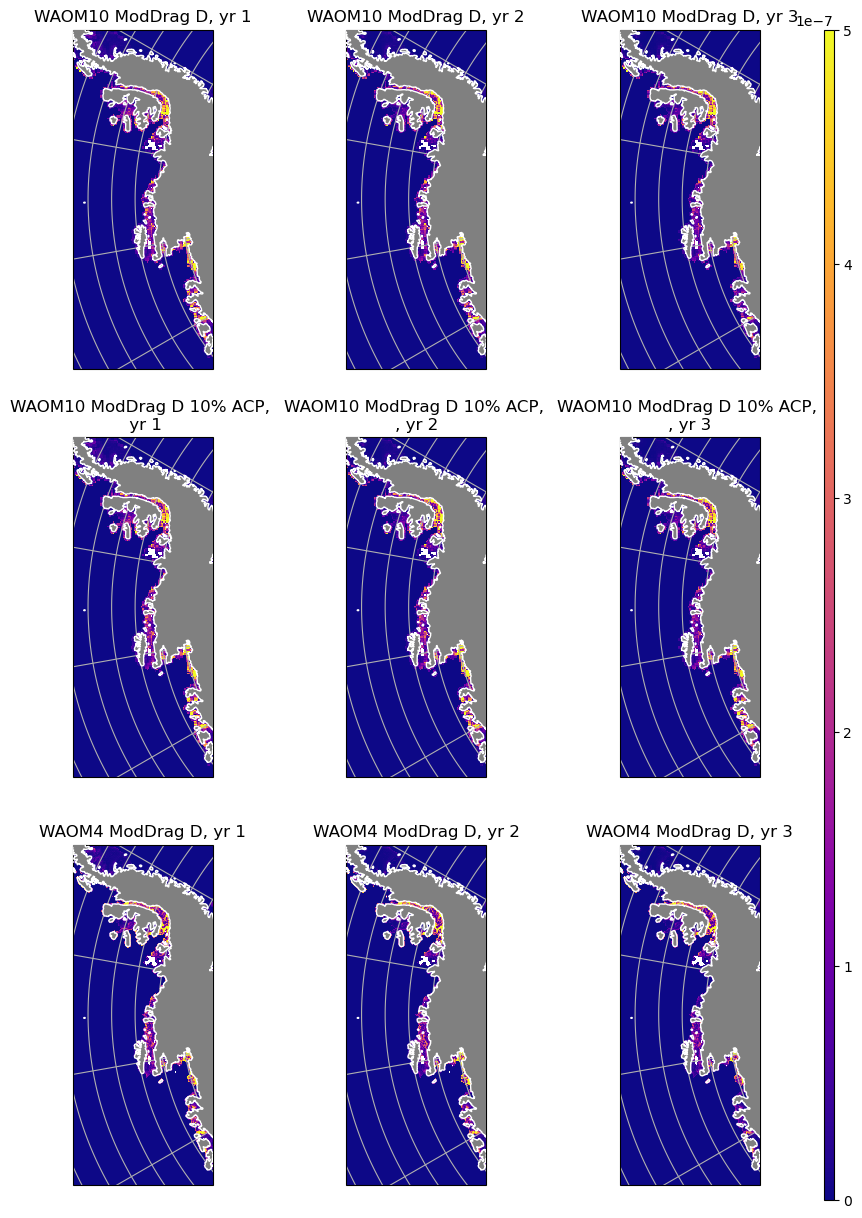

In [22]:
# call cartopy projection
proj = ccrs.SouthPolarStereo()

xmin=-0 #.25e-6
xmax=.5e-6

TFactor=86400*365.25

fig = plt.figure(figsize=(10,15))

ax1 = fig.add_subplot(331, projection=proj)
cs1=plt.pcolormesh(lon_rho_10km,lat_rho_10km,melt_10_mdD.isel(ocean_time=range(0,12)).mean('ocean_time')*mask_shelf_10km*mask_zice_10km*TFactor, transform=ccrs.PlateCarree(), cmap=plt.cm.plasma, vmin=xmin, vmax=xmax)
plt.title('WAOM10 ModDrag D, yr 1')
ax1.set_extent([-120, -60, -68, -75], crs=ccrs.PlateCarree())
ax1.gridlines() # draw_labels=True,linewidth=
ax1.add_feature(cfeature.LAND, zorder=3, edgecolor='white', facecolor='gray')

ax2 = fig.add_subplot(332, projection=proj)
cs1=plt.pcolormesh(lon_rho_10km,lat_rho_10km,melt_10_mdD.isel(ocean_time=range(12,24)).mean('ocean_time')*mask_shelf_10km*mask_zice_10km*TFactor, transform=ccrs.PlateCarree(), cmap=plt.cm.plasma, vmin=xmin, vmax=xmax)
plt.title('WAOM10 ModDrag D, yr 2')
ax2.set_extent([-120, -60, -68, -75], crs=ccrs.PlateCarree())
ax2.gridlines()
ax2.add_feature(cfeature.LAND, zorder=3, edgecolor='white', facecolor='gray')

ax3 = fig.add_subplot(333, projection=proj)
cs1=plt.pcolormesh(lon_rho_10km,lat_rho_10km,melt_10_mdD.isel(ocean_time=range(24,36)).mean('ocean_time')*mask_shelf_10km*mask_zice_10km*TFactor, transform=ccrs.PlateCarree(), cmap=plt.cm.plasma, vmin=xmin, vmax=xmax)
plt.title('WAOM10 ModDrag D, yr 3')
ax3.set_extent([-120, -60, -68, -75], crs=ccrs.PlateCarree())
ax3.gridlines() # draw_labels=True,linewidth=
ax3.add_feature(cfeature.LAND, zorder=3, edgecolor='white', facecolor='gray')

ax3 = fig.add_subplot(334, projection=proj)
cs1=plt.pcolormesh(lon_rho_10km,lat_rho_10km,melt_10_mdD_ACP.isel(ocean_time=range(0,12)).mean('ocean_time')*mask_shelf_10km*mask_zice_10km*TFactor, transform=ccrs.PlateCarree(), cmap=plt.cm.plasma, vmin=xmin, vmax=xmax)
plt.title('WAOM10 ModDrag D 10% ACP, \n yr 1')
ax3.set_extent([-120, -60, -68, -75], crs=ccrs.PlateCarree())
ax3.gridlines() # draw_labels=True,linewidth=
ax3.add_feature(cfeature.LAND, zorder=3, edgecolor='white', facecolor='gray')

ax4 = fig.add_subplot(335, projection=proj)
cs1=plt.pcolormesh(lon_rho_10km,lat_rho_10km,melt_10_mdD_ACP.isel(ocean_time=range(12,24)).mean('ocean_time')*mask_shelf_10km*mask_zice_10km*TFactor, transform=ccrs.PlateCarree(), cmap=plt.cm.plasma, vmin=xmin, vmax=xmax)
plt.title('WAOM10 ModDrag D 10% ACP, \n, yr 2')
ax4.set_extent([-120, -60, -68, -75], crs=ccrs.PlateCarree())
ax4.gridlines()
ax4.add_feature(cfeature.LAND, zorder=3, edgecolor='white', facecolor='gray')

ax5 = fig.add_subplot(336, projection=proj)
cs1=plt.pcolormesh(lon_rho_10km,lat_rho_10km,melt_10_mdD_ACP.isel(ocean_time=range(24,36)).mean('ocean_time')*mask_shelf_10km*mask_zice_10km*TFactor, transform=ccrs.PlateCarree(), cmap=plt.cm.plasma, vmin=xmin, vmax=xmax)
plt.title('WAOM10 ModDrag D 10% ACP, \n, yr 3')
ax5.set_extent([-120, -60, -68, -75], crs=ccrs.PlateCarree())
ax5.gridlines() # draw_labels=True,linewidth=
ax5.add_feature(cfeature.LAND, zorder=3, edgecolor='white', facecolor='gray')

ax7 = fig.add_subplot(337, projection=proj)
cs1=plt.pcolormesh(lon_rho_4km,lat_rho_4km,melt_4_mdD.isel(ocean_time=range(0,12)).mean('ocean_time')*mask_shelf_4km*mask_zice_4km, transform=ccrs.PlateCarree(), cmap=plt.cm.plasma, vmin=xmin, vmax=xmax)
plt.title('WAOM4 ModDrag D, yr 1')
ax7.set_extent([-120, -60, -68, -75], crs=ccrs.PlateCarree())
ax7.gridlines()
ax7.add_feature(cfeature.LAND, zorder=3, edgecolor='white', facecolor='gray')
ax8 = fig.add_subplot(338, projection=proj)
cs1=plt.pcolormesh(lon_rho_4km,lat_rho_4km,melt_4_mdD.isel(ocean_time=range(12,24)).mean('ocean_time')*mask_shelf_4km*mask_zice_4km, transform=ccrs.PlateCarree(), cmap=plt.cm.plasma, vmin=xmin, vmax=xmax)
plt.title('WAOM4 ModDrag D, yr 2')
ax8.set_extent([-120, -60, -68, -75], crs=ccrs.PlateCarree())
ax8.gridlines() # draw_labels=True,linewidth=
ax8.add_feature(cfeature.LAND, zorder=3, edgecolor='white', facecolor='gray')

ax9 = fig.add_subplot(339, projection=proj)
cs1=plt.pcolormesh(lon_rho_4km,lat_rho_4km,melt_4_mdD.isel(ocean_time=range(24,36)).mean('ocean_time')*mask_shelf_4km*mask_zice_4km, transform=ccrs.PlateCarree(), cmap=plt.cm.plasma, vmin=xmin, vmax=xmax)
plt.title('WAOM4 ModDrag D, yr 3')
ax9.set_extent([-120, -60, -68, -75], crs=ccrs.PlateCarree())
ax9.gridlines()
ax9.add_feature(cfeature.LAND, zorder=3, edgecolor='white', facecolor='gray')
# cbar_ax3 = fig.add_axes([0.04, 0.05, 0.01, 0.8])
# fig.colorbar(cs1, cax=cbar_ax3, orientation='vertical')
# cbar_ax3.set_ylabel('$^{\circ}$C')#, labelpad=-35)

cbar_ax4 = fig.add_axes([0.92, 0.1, 0.01, 0.78])
fig.colorbar(cs1, cax=cbar_ax4, orientation='vertical')
cbar_ax4.set_xlabel('')#, labelpad=-35)

name_fig='waom10x4e_ModDrag_bottomMeltmaps_yr1-3.png'
plt.savefig(fig_path + name_fig, dpi=300)


## plot together (annual avg) basal melt rates, shflux and ssflux for waom10e ModDragD for years 1-3:

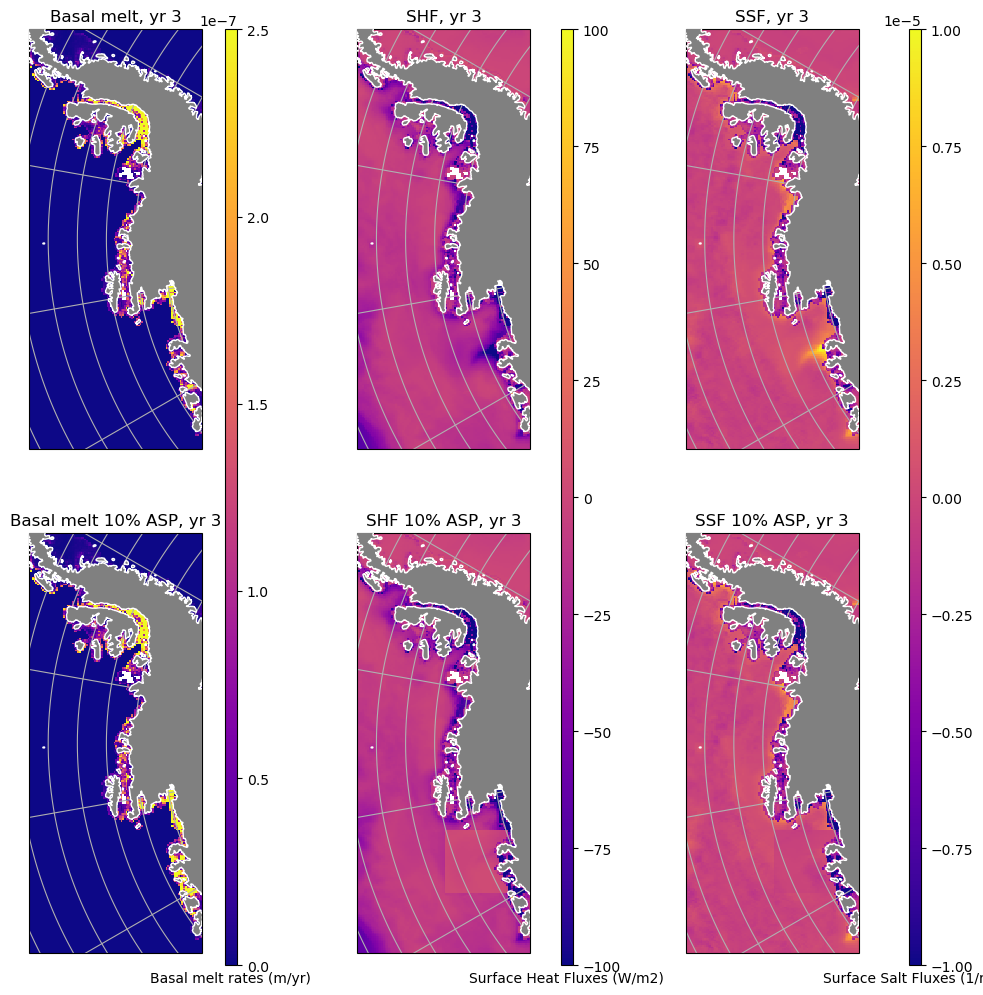

In [28]:
# call cartopy projection
proj = ccrs.SouthPolarStereo()

mmin=-0 #.25e-6
mmax=.25e-6

xmin=-100
xmax=100

ymin=-1e-5
ymax=1e-5

fig = plt.figure(figsize=(12,12))

ax1 = fig.add_subplot(231, projection=proj)
cm1=plt.pcolormesh(lon_rho_10km,lat_rho_10km,melt_10_mdD.isel(ocean_time=range(24,36)).mean('ocean_time')*mask_shelf_10km*mask_zice_10km*TFactor, transform=ccrs.PlateCarree(), cmap=plt.cm.plasma, vmin=mmin, vmax=mmax)
plt.title('Basal melt, yr 3')
ax1.set_extent([-120, -60, -68, -75], crs=ccrs.PlateCarree())
ax1.gridlines() # draw_labels=True,linewidth=
ax1.add_feature(cfeature.LAND, zorder=3, edgecolor='white', facecolor='gray')

ax2 = fig.add_subplot(234, projection=proj)
cm1=plt.pcolormesh(lon_rho_10km,lat_rho_10km,melt_10_mdD_ACP.isel(ocean_time=range(24,36)).mean('ocean_time')*mask_shelf_10km*mask_zice_10km*TFactor, transform=ccrs.PlateCarree(), cmap=plt.cm.plasma, vmin=mmin, vmax=mmax)
plt.title('Basal melt 10% ASP, yr 3')
ax2.set_extent([-120, -60, -68, -75], crs=ccrs.PlateCarree())
ax2.gridlines()
ax2.add_feature(cfeature.LAND, zorder=3, edgecolor='white', facecolor='gray')

ax3 = fig.add_subplot(232, projection=proj)
ct1=plt.pcolormesh(lon_rho_10km,lat_rho_10km,shflux_10_mdD.isel(ocean_time=range(24,36)).mean('ocean_time')*mask_shelf_10km*mask_zice_10km, transform=ccrs.PlateCarree(), cmap=plt.cm.plasma, vmin=xmin, vmax=xmax)
plt.title('SHF, yr 3')
ax3.set_extent([-120, -60, -68, -75], crs=ccrs.PlateCarree())
ax3.gridlines() # draw_labels=True,linewidth=
ax3.add_feature(cfeature.LAND, zorder=3, edgecolor='white', facecolor='gray')

ax4 = fig.add_subplot(235, projection=proj)
ct1=plt.pcolormesh(lon_rho_10km,lat_rho_10km,shflux_10_mdD_ACP.isel(ocean_time=range(24,36)).mean('ocean_time')*mask_shelf_10km*mask_zice_10km, transform=ccrs.PlateCarree(), cmap=plt.cm.plasma, vmin=xmin, vmax=xmax)
plt.title('SHF 10% ASP, yr 3')
ax4.set_extent([-120, -60, -68, -75], crs=ccrs.PlateCarree())
ax4.gridlines()
ax4.add_feature(cfeature.LAND, zorder=3, edgecolor='white', facecolor='gray')

ax5 = fig.add_subplot(233, projection=proj)
cs1=plt.pcolormesh(lon_rho_10km,lat_rho_10km,ssflux_10_mdD.isel(ocean_time=range(24,36)).mean('ocean_time')*mask_shelf_10km*mask_zice_10km, transform=ccrs.PlateCarree(), cmap=plt.cm.plasma, vmin=ymin, vmax=ymax)
plt.title('SSF, yr 3')
ax5.set_extent([-120, -60, -68, -75], crs=ccrs.PlateCarree())
ax5.gridlines()
ax5.add_feature(cfeature.LAND, zorder=3, edgecolor='white', facecolor='gray')

ax6 = fig.add_subplot(236, projection=proj)
cs1=plt.pcolormesh(lon_rho_10km,lat_rho_10km,ssflux_10_mdD_ACP.isel(ocean_time=range(24,36)).mean('ocean_time')*mask_shelf_10km*mask_zice_10km, transform=ccrs.PlateCarree(), cmap=plt.cm.plasma, vmin=ymin, vmax=ymax)
plt.title('SSF 10% ASP, yr 3')
ax6.set_extent([-120, -60, -68, -75], crs=ccrs.PlateCarree())
ax6.gridlines() # draw_labels=True,linewidth=
ax6.add_feature(cfeature.LAND, zorder=3, edgecolor='white', facecolor='gray')

cbar_ax3 = fig.add_axes([0.33, 0.1, 0.01, 0.78])
fig.colorbar(cm1, cax=cbar_ax3, orientation='vertical')
cbar_ax3.set_xlabel('Basal melt rates (m/yr)')#, labelpad=-35)

cbar_ax4 = fig.add_axes([0.61, 0.1, 0.01, 0.78])
fig.colorbar(ct1, cax=cbar_ax4, orientation='vertical')
cbar_ax4.set_xlabel('Surface Heat Fluxes (W/m2)')#, labelpad=-35)

cbar_ax5 = fig.add_axes([0.90, 0.1, 0.01, 0.78])
fig.colorbar(cs1, cax=cbar_ax5, orientation='vertical')
cbar_ax5.set_xlabel('Surface Salt Fluxes (1/m2)')#, labelpad=-35)

name_fig='waom10e_ModDrag_bottomSfcFluxes_maps_yr3.png'
plt.savefig(fig_path + name_fig, dpi=300)


In [ ]:
# call cartopy projection
proj = ccrs.SouthPolarStereo()

mmin=-0 #.25e-6
mmax=.25e-6

xmin=-100
xmax=100

ymin=-1e-5
ymax=1e-5

fig = plt.figure(figsize=(7,15))

ax1 = fig.add_subplot(231, projection=proj)
cm1=plt.pcolormesh(lon_rho_10km,lat_rho_10km,melt_10_mdD.isel(ocean_tim=8)*mask_shelf_10km*mask_zice_10km*TFactor, transform=ccrs.PlateCarree(), cmap=plt.cm.plasma, vmin=mmin, vmax=mmax)
plt.title('Basal melt, yr 3')
ax1.set_extent([-120, -60, -68, -75], crs=ccrs.PlateCarree())
ax1.gridlines() # draw_labels=True,linewidth=
ax1.add_feature(cfeature.LAND, zorder=3, edgecolor='white', facecolor='gray')

ax2 = fig.add_subplot(234, projection=proj)
cm1=plt.pcolormesh(lon_rho_10km,lat_rho_10km,melt_10_mdD_ACP.isel(ocean_tim=8)*mask_shelf_10km*mask_zice_10km*TFactor, transform=ccrs.PlateCarree(), cmap=plt.cm.plasma, vmin=mmin, vmax=mmax)
plt.title('Basal melt 10% ASP, yr 3')
ax2.set_extent([-120, -60, -68, -75], crs=ccrs.PlateCarree())
ax2.gridlines()
ax2.add_feature(cfeature.LAND, zorder=3, edgecolor='white', facecolor='gray')

ax3 = fig.add_subplot(232, projection=proj)
ct1=plt.pcolormesh(lon_rho_10km,lat_rho_10km,shflux_10_mdD.isel(ocean_tim=8)*mask_shelf_10km*mask_zice_10km, transform=ccrs.PlateCarree(), cmap=plt.cm.plasma, vmin=xmin, vmax=xmax)
plt.title('SHF, yr 3')
ax3.set_extent([-120, -60, -68, -75], crs=ccrs.PlateCarree())
ax3.gridlines() # draw_labels=True,linewidth=
ax3.add_feature(cfeature.LAND, zorder=3, edgecolor='white', facecolor='gray')

ax4 = fig.add_subplot(235, projection=proj)
ct1=plt.pcolormesh(lon_rho_10km,lat_rho_10km,shflux_10_mdD_ACP.isel(ocean_tim=8)*mask_shelf_10km*mask_zice_10km, transform=ccrs.PlateCarree(), cmap=plt.cm.plasma, vmin=xmin, vmax=xmax)
plt.title('SHF 10% ASP, yr 3')
ax4.set_extent([-120, -60, -68, -75], crs=ccrs.PlateCarree())
ax4.gridlines()
ax4.add_feature(cfeature.LAND, zorder=3, edgecolor='white', facecolor='gray')

ax5 = fig.add_subplot(233, projection=proj)
cs1=plt.pcolormesh(lon_rho_10km,lat_rho_10km,ssflux_10_mdD.isel(ocean_tim=8)*mask_shelf_10km*mask_zice_10km, transform=ccrs.PlateCarree(), cmap=plt.cm.plasma, vmin=ymin, vmax=ymax)
plt.title('SSF, yr 1')
ax5.set_extent([-120, -60, -68, -75], crs=ccrs.PlateCarree())
ax5.gridlines()
ax5.add_feature(cfeature.LAND, zorder=3, edgecolor='white', facecolor='gray')

ax6 = fig.add_subplot(236, projection=proj)
cs1=plt.pcolormesh(lon_rho_10km,lat_rho_10km,ssflux_10_mdD_ACP.isel(ocean_tim=8)*mask_shelf_10km*mask_zice_10km, transform=ccrs.PlateCarree(), cmap=plt.cm.plasma, vmin=ymin, vmax=ymax)
plt.title('SSF 10% ASP, yr 2')
ax6.set_extent([-120, -60, -68, -75], crs=ccrs.PlateCarree())
ax6.gridlines() # draw_labels=True,linewidth=
ax6.add_feature(cfeature.LAND, zorder=3, edgecolor='white', facecolor='gray')

cbar_ax3 = fig.add_axes([0.32, 0.1, 0.01, 0.78])
fig.colorbar(cm1, cax=cbar_ax3, orientation='vertical')
cbar_ax3.set_xlabel('Basal melt rates (m/yr)')#, labelpad=-35)

cbar_ax4 = fig.add_axes([0.62, 0.1, 0.01, 0.78])
fig.colorbar(ct1, cax=cbar_ax4, orientation='vertical')
cbar_ax4.set_xlabel('Surface Heat Fluxes (W/m2)')#, labelpad=-35)

cbar_ax5 = fig.add_axes([0.92, 0.1, 0.01, 0.78])
fig.colorbar(cs1, cax=cbar_ax5, orientation='vertical')
cbar_ax5.set_xlabel('Surface Salt Fluxes (m-2)')#, labelpad=-35)

name_fig='waom10e_ModDrag_bottomSfcFluxes_maps_yr3.png'
plt.savefig(fig_path + name_fig, dpi=300)

name_fig='waom10e_ModDrag_bottomSfcFluxes_maps_Sept-yr3.png'
plt.savefig(fig_path + name_fig, dpi=300)


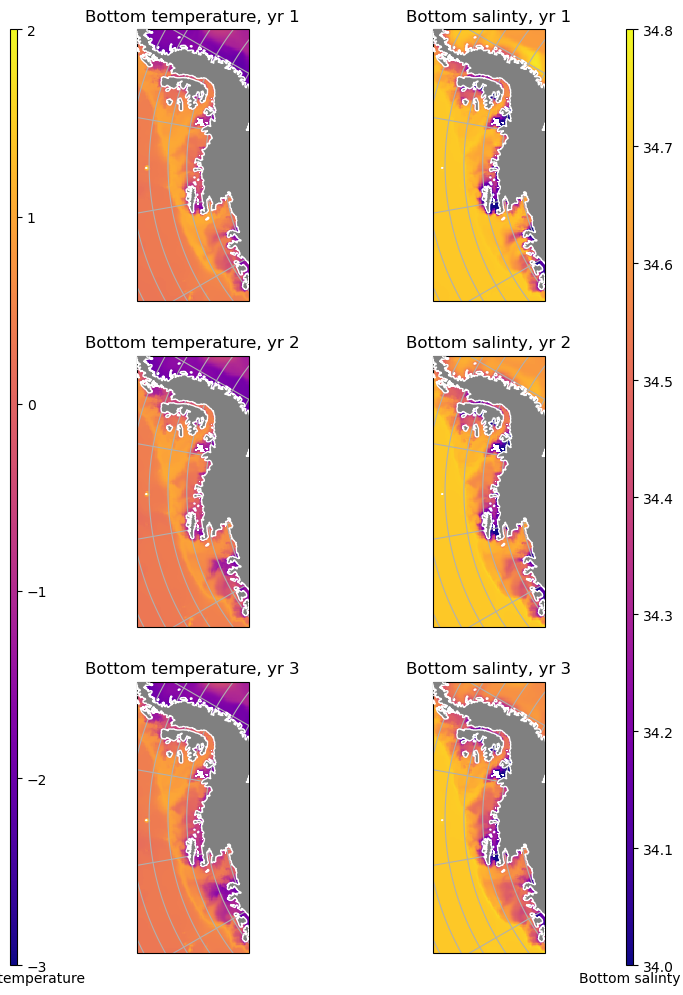

In [39]:
# call cartopy projection
proj = ccrs.SouthPolarStereo()


xmin=-3
xmax=2
ymin=34
ymax=34.8

fig = plt.figure(figsize=(7,12))

ax1 = fig.add_subplot(321, projection=proj)
ct1=plt.pcolormesh(lon_rho_10km,lat_rho_10km,temp_10_mdD.isel(s_rho=0, ocean_time=8)*mask_shelf_10km*mask_zice_10km, transform=ccrs.PlateCarree(), cmap=plt.cm.plasma, vmin=xmin, vmax=xmax)
plt.title('Bottom temperature, yr 1')
ax1.set_extent([-120, -60, -68, -75], crs=ccrs.PlateCarree())
ax1.gridlines() # draw_labels=True,linewidth=
ax1.add_feature(cfeature.LAND, zorder=3, edgecolor='white', facecolor='gray')

ax2 = fig.add_subplot(323, projection=proj)
ct1=plt.pcolormesh(lon_rho_10km,lat_rho_10km,temp_10_mdD.isel(s_rho=0, ocean_time=20)*mask_shelf_10km*mask_zice_10km, transform=ccrs.PlateCarree(), cmap=plt.cm.plasma, vmin=xmin, vmax=xmax)
plt.title('Bottom temperature, yr 2')
ax2.set_extent([-120, -60, -68, -75], crs=ccrs.PlateCarree())
ax2.gridlines()
ax2.add_feature(cfeature.LAND, zorder=3, edgecolor='white', facecolor='gray')

ax3 = fig.add_subplot(325, projection=proj)
ct1=plt.pcolormesh(lon_rho_10km,lat_rho_10km,temp_10_mdD.isel(s_rho=0, ocean_time=32)*mask_shelf_10km*mask_zice_10km, transform=ccrs.PlateCarree(), cmap=plt.cm.plasma, vmin=xmin, vmax=xmax)
plt.title('Bottom temperature, yr 3')
ax3.set_extent([-120, -60, -68, -75], crs=ccrs.PlateCarree())
ax3.gridlines() # draw_labels=True,linewidth=
ax3.add_feature(cfeature.LAND, zorder=3, edgecolor='white', facecolor='gray')

ax4 = fig.add_subplot(322, projection=proj)
cs1=plt.pcolormesh(lon_rho_10km,lat_rho_10km,salt_10_mdD.isel(s_rho=0, ocean_time=8)*mask_shelf_10km*mask_zice_10km, transform=ccrs.PlateCarree(), cmap=plt.cm.plasma, vmin=ymin, vmax=ymax)
plt.title('Bottom salinty, yr 1')
ax4.set_extent([-120, -60, -68, -75], crs=ccrs.PlateCarree())
ax4.gridlines()
ax4.add_feature(cfeature.LAND, zorder=3, edgecolor='white', facecolor='gray')

ax5 = fig.add_subplot(324, projection=proj)
cs1=plt.pcolormesh(lon_rho_10km,lat_rho_10km,salt_10_mdD.isel(s_rho=0, ocean_time=20)*mask_shelf_10km*mask_zice_10km, transform=ccrs.PlateCarree(), cmap=plt.cm.plasma, vmin=ymin, vmax=ymax)
plt.title('Bottom salinty, yr 2')
ax5.set_extent([-120, -60, -68, -75], crs=ccrs.PlateCarree())
ax5.gridlines() # draw_labels=True,linewidth=
ax5.add_feature(cfeature.LAND, zorder=3, edgecolor='white', facecolor='gray')

ax6 = fig.add_subplot(326, projection=proj)
cs1=plt.pcolormesh(lon_rho_10km,lat_rho_10km,salt_10_mdD.isel(s_rho=0, ocean_time=32)*mask_shelf_10km*mask_zice_10km, transform=ccrs.PlateCarree(), cmap=plt.cm.plasma, vmin=ymin, vmax=ymax)
plt.title('Bottom salinty, yr 3')
ax6.set_extent([-120, -60, -68, -75], crs=ccrs.PlateCarree())
ax6.gridlines()
ax6.add_feature(cfeature.LAND, zorder=3, edgecolor='white', facecolor='gray')

cbar_ax4 = fig.add_axes([0.04, 0.1, 0.01, 0.78])
fig.colorbar(ct1, cax=cbar_ax4, orientation='vertical')
cbar_ax4.set_xlabel('Bottom temperature')#, labelpad=-35)

cbar_ax5 = fig.add_axes([0.92, 0.1, 0.01, 0.78])
fig.colorbar(cs1, cax=cbar_ax5, orientation='vertical')
cbar_ax5.set_xlabel('Bottom salinty')#, labelpad=-35)

name_fig='waom10e_ModDrag_bottomTS_maps_Sept_yr1-3.png'
plt.savefig(fig_path + name_fig, dpi=300)


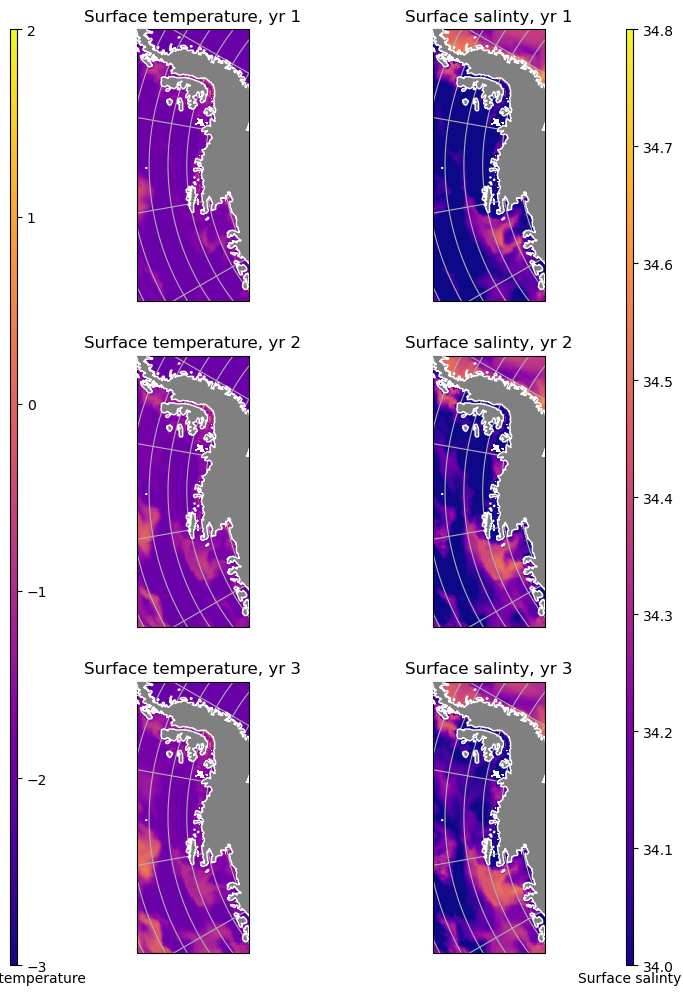

In [40]:
# call cartopy projection
proj = ccrs.SouthPolarStereo()


xmin=-3
xmax=2
ymin=34
ymax=34.8

fig = plt.figure(figsize=(7,12))

ax1 = fig.add_subplot(321, projection=proj)
ct1=plt.pcolormesh(lon_rho_10km,lat_rho_10km,temp_10_mdD.isel(s_rho=-1, ocean_time=8)*mask_shelf_10km*mask_zice_10km, transform=ccrs.PlateCarree(), cmap=plt.cm.plasma, vmin=xmin, vmax=xmax)
plt.title('Surface temperature, yr 1')
ax1.set_extent([-120, -60, -68, -75], crs=ccrs.PlateCarree())
ax1.gridlines() # draw_labels=True,linewidth=
ax1.add_feature(cfeature.LAND, zorder=3, edgecolor='white', facecolor='gray')

ax2 = fig.add_subplot(323, projection=proj)
ct1=plt.pcolormesh(lon_rho_10km,lat_rho_10km,temp_10_mdD.isel(s_rho=-1, ocean_time=20)*mask_shelf_10km*mask_zice_10km, transform=ccrs.PlateCarree(), cmap=plt.cm.plasma, vmin=xmin, vmax=xmax)
plt.title('Surface temperature, yr 2')
ax2.set_extent([-120, -60, -68, -75], crs=ccrs.PlateCarree())
ax2.gridlines()
ax2.add_feature(cfeature.LAND, zorder=3, edgecolor='white', facecolor='gray')

ax3 = fig.add_subplot(325, projection=proj)
ct1=plt.pcolormesh(lon_rho_10km,lat_rho_10km,temp_10_mdD.isel(s_rho=-1, ocean_time=32)*mask_shelf_10km*mask_zice_10km, transform=ccrs.PlateCarree(), cmap=plt.cm.plasma, vmin=xmin, vmax=xmax)
plt.title('Surface temperature, yr 3')
ax3.set_extent([-120, -60, -68, -75], crs=ccrs.PlateCarree())
ax3.gridlines() # draw_labels=True,linewidth=
ax3.add_feature(cfeature.LAND, zorder=3, edgecolor='white', facecolor='gray')

ax4 = fig.add_subplot(322, projection=proj)
cs1=plt.pcolormesh(lon_rho_10km,lat_rho_10km,salt_10_mdD.isel(s_rho=-1, ocean_time=8)*mask_shelf_10km*mask_zice_10km, transform=ccrs.PlateCarree(), cmap=plt.cm.plasma, vmin=ymin, vmax=ymax)
plt.title('Surface salinty, yr 1')
ax4.set_extent([-120, -60, -68, -75], crs=ccrs.PlateCarree())
ax4.gridlines()
ax4.add_feature(cfeature.LAND, zorder=3, edgecolor='white', facecolor='gray')

ax5 = fig.add_subplot(324, projection=proj)
cs1=plt.pcolormesh(lon_rho_10km,lat_rho_10km,salt_10_mdD.isel(s_rho=-1, ocean_time=20)*mask_shelf_10km*mask_zice_10km, transform=ccrs.PlateCarree(), cmap=plt.cm.plasma, vmin=ymin, vmax=ymax)
plt.title('Surface salinty, yr 2')
ax5.set_extent([-120, -60, -68, -75], crs=ccrs.PlateCarree())
ax5.gridlines() # draw_labels=True,linewidth=
ax5.add_feature(cfeature.LAND, zorder=3, edgecolor='white', facecolor='gray')

ax6 = fig.add_subplot(326, projection=proj)
cs1=plt.pcolormesh(lon_rho_10km,lat_rho_10km,salt_10_mdD.isel(s_rho=-1, ocean_time=32)*mask_shelf_10km*mask_zice_10km, transform=ccrs.PlateCarree(), cmap=plt.cm.plasma, vmin=ymin, vmax=ymax)
plt.title('Surface salinty, yr 3')
ax6.set_extent([-120, -60, -68, -75], crs=ccrs.PlateCarree())
ax6.gridlines()
ax6.add_feature(cfeature.LAND, zorder=3, edgecolor='white', facecolor='gray')

cbar_ax4 = fig.add_axes([0.04, 0.1, 0.01, 0.78])
fig.colorbar(ct1, cax=cbar_ax4, orientation='vertical')
cbar_ax4.set_xlabel('Surface temperature')#, labelpad=-35)

cbar_ax5 = fig.add_axes([0.92, 0.1, 0.01, 0.78])
fig.colorbar(cs1, cax=cbar_ax5, orientation='vertical')
cbar_ax5.set_xlabel('Surface salinty')#, labelpad=-35)

name_fig='waom10e_ModDrag_SurfaceTS_maps_Sept_yr1-3.png'
plt.savefig(fig_path + name_fig, dpi=300)


# OLD STUFFS:

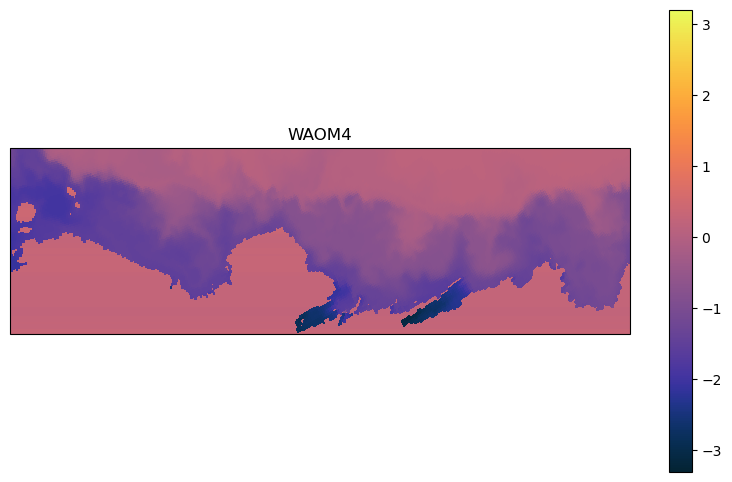

In [15]:
fig = plt.figure(figsize=(10,6))

proj = ccrs.PlateCarree(central_longitude=115.0)
ratio = .3
ax = fig.add_subplot(111, projection=proj)
ct1=plt.pcolormesh(lon_rho_10km,lat_rho_10km,temp_10km.isel(s_rho=0).mean('ocean_time'), transform=ccrs.PlateCarree(), cmap=cmocean.cm.thermal)#, vminmin, vmax=smax)
plt.colorbar()
ax.set_extent([100, 130, -64.5, -67.5], crs=ccrs.PlateCarree())
plt.title('WAOM4')
gl = ax4.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=.5, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_left = False
gl.xlines = True
gl.xlocator = mticker.FixedLocator([105, 110, 120, 125])
gl.ylocator = mticker.FixedLocator([-65, -66, -67])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 9, 'color': 'gray'}
gl.ylabel_style = {'size': 9, 'color': 'gray'}
ax.set_extent([100, 130, -64.5, -67.5], crs=ccrs.PlateCarree())
# ax.add_feature(cfeature.LAND, zorder=1, facecolor='lightgray') #edgecolor='white',
x_left, x_right = ax.get_xlim()
y_low, y_high = ax.get_ylim()
ax.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)

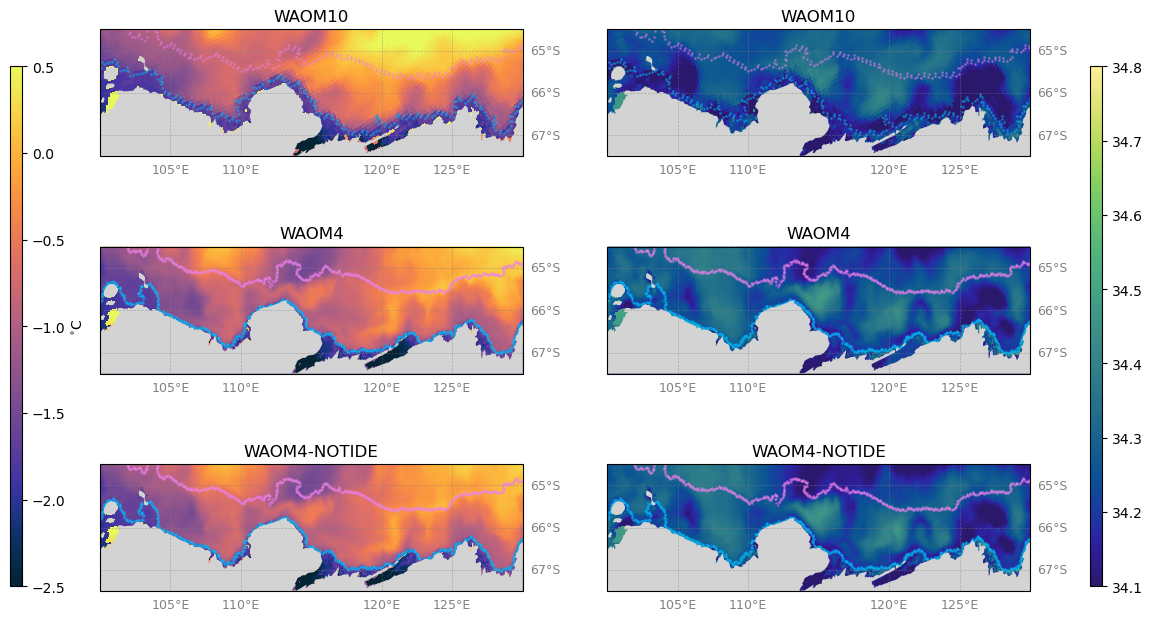

In [16]:
# --------------------------------------------------------------------------
# zoomm near TIS/MUIS

# --- bottom

fig = plt.figure(figsize=(12,8))

proj = ccrs.PlateCarree(central_longitude=115.0)
ratio = .3

ax1 = fig.add_subplot(321, projection=proj)
ct1=plt.pcolormesh(lon_rho_10km,lat_rho_10km,temp_10km.isel(s_rho=-1).mean('ocean_time'), transform=ccrs.PlateCarree(), cmap=cmocean.cm.thermal, vmin=tmin, vmax=tmax)
plt.scatter(lon_along_10km_CF,lat_along_10km_CF, s=1, alpha=0.4, color='deepskyblue',label='Calving front', transform=ccrs.PlateCarree());
plt.scatter(lon_along_10km_shelf,lat_along_10km_shelf, s=1, alpha=0.4, color='violet',label='1500m isobath', transform=ccrs.PlateCarree());
plt.title('WAOM10')
gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=.5, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_left = False
gl.xlines = True
gl.xlocator = mticker.FixedLocator([105, 110, 120, 125])
gl.ylocator = mticker.FixedLocator([-65, -66, -67])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 9, 'color': 'gray'}
gl.ylabel_style = {'size': 9, 'color': 'gray'}
ax1.set_extent([100, 130, -64.5, -67.5], crs=ccrs.PlateCarree())
ax1.add_feature(cfeature.LAND, zorder=1, facecolor='lightgray') #edgecolor='white',
x_left, x_right = ax1.get_xlim()
y_low, y_high = ax1.get_ylim()
ax1.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)

ax2 = fig.add_subplot(322, projection=proj)
cs1=plt.pcolormesh(lon_rho_10km,lat_rho_10km,shflux_10km.isel(s_rho=-1).mean('ocean_time'), transform=ccrs.PlateCarree(), cmap=cmocean.cm.haline, vmin=smin, vmax=smax)
plt.scatter(lon_along_10km_CF,lat_along_10km_CF, s=1, alpha=0.4, color='deepskyblue',label='Calving front', transform=ccrs.PlateCarree());
plt.scatter(lon_along_10km_shelf,lat_along_10km_shelf, s=1, alpha=0.4, color='violet',label='1500m isobath', transform=ccrs.PlateCarree());
plt.title('WAOM10')
gl = ax2.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=.5, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_left = False
gl.xlines = True
gl.xlocator = mticker.FixedLocator([105, 110, 120, 125])
gl.ylocator = mticker.FixedLocator([-65, -66, -67])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 9, 'color': 'gray'}
gl.ylabel_style = {'size': 9, 'color': 'gray'}
ax2.set_extent([100, 130, -64.5, -67.5], crs=ccrs.PlateCarree())
ax2.add_feature(cfeature.LAND, zorder=1, facecolor='lightgray') #edgecolor='white',
x_left, x_right = ax2.get_xlim()
y_low, y_high = ax2.get_ylim()
ax2.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)

ax3 = fig.add_subplot(323, projection=proj)
ct1=plt.pcolormesh(lon_rho_10km,lat_rho_10km,temp_10km.isel(s_rho=-1).mean('ocean_time'), transform=ccrs.PlateCarree(), cmap=cmocean.cm.thermal, vmin=tmin, vmax=tmax)
plt.scatter(lon_along_10km_CF,lat_along_10km_CF, s=1, alpha=0.4, color='deepskyblue',label='Calving front', transform=ccrs.PlateCarree());
plt.scatter(lon_along_10km_shelf,lat_along_10km_shelf, s=1, alpha=0.4, color='violet',label='1500m isobath', transform=ccrs.PlateCarree());
plt.title('WAOM4')
gl = ax3.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=.5, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_left = False
gl.xlines = True
gl.xlocator = mticker.FixedLocator([105, 110, 120, 125])
gl.ylocator = mticker.FixedLocator([-65, -66, -67])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 9, 'color': 'gray'}
gl.ylabel_style = {'size': 9, 'color': 'gray'}
ax3.set_extent([100, 130, -64.5, -67.5], crs=ccrs.PlateCarree())
ax3.add_feature(cfeature.LAND, zorder=1, facecolor='lightgray') #edgecolor='white',
x_left, x_right = ax3.get_xlim()
y_low, y_high = ax3.get_ylim()
ax3.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)

ax4 = fig.add_subplot(324, projection=proj)
cs1=plt.pcolormesh(lon_rho_10km,lat_rho_10km,shflux_10km.isel(s_rho=-1).mean('ocean_time'), transform=ccrs.PlateCarree(), cmap=cmocean.cm.haline, vmin=smin, vmax=smax)
plt.scatter(lon_along_10km_CF,lat_along_10km_CF, s=1, alpha=0.4, color='deepskyblue',label='Calving front', transform=ccrs.PlateCarree());
plt.scatter(lon_along_10km_shelf,lat_along_10km_shelf, s=1, alpha=0.4, color='violet',label='1500m isobath', transform=ccrs.PlateCarree());
plt.title('WAOM4')
gl = ax4.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=.5, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_left = False
gl.xlines = True
gl.xlocator = mticker.FixedLocator([105, 110, 120, 125])
gl.ylocator = mticker.FixedLocator([-65, -66, -67])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 9, 'color': 'gray'}
gl.ylabel_style = {'size': 9, 'color': 'gray'}
ax4.set_extent([100, 130, -64.5, -67.5], crs=ccrs.PlateCarree())
ax4.add_feature(cfeature.LAND, zorder=1, facecolor='lightgray') #edgecolor='white',
x_left, x_right = ax4.get_xlim()
y_low, y_high = ax4.get_ylim()
ax4.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)

ax5 = fig.add_subplot(325, projection=proj)
ct1=plt.pcolormesh(lon_rho_10km,lat_rho_10km,temp_10kmNT.isel(s_rho=-1).mean('ocean_time'), transform=ccrs.PlateCarree(), cmap=cmocean.cm.thermal, vmin=tmin, vmax=tmax)
plt.scatter(lon_along_10km_CF,lat_along_10km_CF, s=1, alpha=0.4, color='deepskyblue',label='Calving front', transform=ccrs.PlateCarree());
plt.scatter(lon_along_10km_shelf,lat_along_10km_shelf, s=1, alpha=0.4, color='violet',label='1500m isobath', transform=ccrs.PlateCarree());
plt.title('WAOM4-NOTIDE')
gl = ax5.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=.5, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_left = False
gl.xlines = True
gl.xlocator = mticker.FixedLocator([105, 110, 120, 125])
gl.ylocator = mticker.FixedLocator([-65, -66, -67])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 9, 'color': 'gray'}
gl.ylabel_style = {'size': 9, 'color': 'gray'}
ax5.set_extent([100, 130, -64.5, -67.5], crs=ccrs.PlateCarree())
ax5.add_feature(cfeature.LAND, zorder=1, facecolor='lightgray') #edgecolor='white',
x_left, x_right = ax5.get_xlim()
y_low, y_high = ax5.get_ylim()
ax5.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)

ax6 = fig.add_subplot(326, projection=proj)
cs1=plt.pcolormesh(lon_rho_10km,lat_rho_10km,shflux_10kmNT.isel(s_rho=-1).mean('ocean_time'), transform=ccrs.PlateCarree(), cmap=cmocean.cm.haline, vmin=smin, vmax=smax)
plt.scatter(lon_along_10km_CF,lat_along_10km_CF, s=1, alpha=0.4, color='deepskyblue',label='Calving front', transform=ccrs.PlateCarree());
plt.scatter(lon_along_10km_shelf,lat_along_10km_shelf, s=1, alpha=0.4, color='violet',label='1500m isobath', transform=ccrs.PlateCarree());
plt.title('WAOM4-NOTIDE')
gl = ax6.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=.5, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_left = False
gl.xlines = True
gl.xlocator = mticker.FixedLocator([105, 110, 120, 125])
gl.ylocator = mticker.FixedLocator([-65, -66, -67])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 9, 'color': 'gray'}
gl.ylabel_style = {'size': 9, 'color': 'gray'}
ax6.set_extent([100, 130, -64.5, -67.5], crs=ccrs.PlateCarree())
ax6.add_feature(cfeature.LAND, zorder=1, facecolor='lightgray') #edgecolor='white',
x_left, x_right = ax6.get_xlim()
y_low, y_high = ax6.get_ylim()
ax6.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)

cbar_ax1 = fig.add_axes([0.05, 0.15, 0.01, 0.65])
fig.colorbar(ct1, cax=cbar_ax1, orientation='vertical')
cbar_ax1.set_ylabel('$^{\circ}$C')#, labelpad=-35)

cbar_ax2 = fig.add_axes([0.95, 0.15, 0.01, 0.65])
fig.colorbar(cs1, cax=cbar_ax2, orientation='vertical')
cbar_ax2.set_xlabel('')#, labelpad=-35)

name_fig='waom10x4x4-NOTIDE_sfcTSmaps_yr10_EAntTIS.png'
plt.savefig(fig_path + name_fig, dpi=300)
# plt.close()

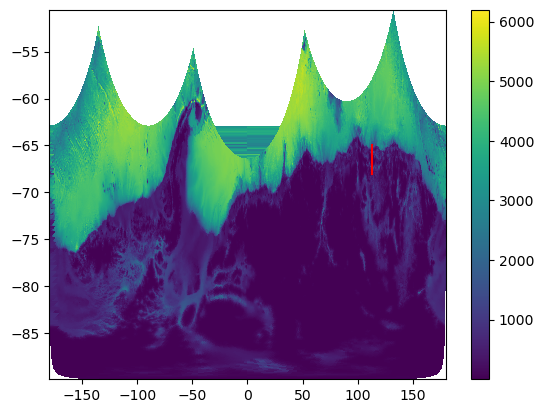

In [17]:
## transecto at 113.5E (Pena-Molino et al 2016)

# ct1=plt.pcolormesh(lon_rho_10km,lat_rho_10km,temp_10km.isel(s_rho=0).mean('ocean_time'), transform=ccrs.PlateCarree(), cmap=cmocean.cm.thermal, vmin=tmin, vmax=tmax)
# ct1=plt.pcolormesh(lon_rho_10km,lat_rho_10km,temp_10km.isel(s_rho=0).mean('ocean_time'), transform=ccrs.PlateCarree(), cmap=cmocean.cm.thermal, vmin=tmin, vmax=tmax)


plt.pcolormesh(lon_rho_10km,lat_rho_10km,h_10km)
plt.colorbar()
plt.plot([113,113],[-68,-65],'r')


(150.0, 250.0)

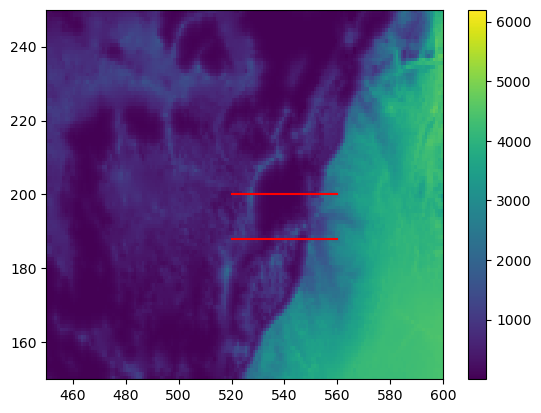

In [18]:
xi_ind = [520,560]
eta_ind = [188,188]

xi_ind2 = [520,560]
eta_ind2 = [200,200]

plt.pcolormesh(h_10km)
plt.colorbar()
plt.plot(xi_ind,eta_ind,'r')
plt.plot(xi_ind2,eta_ind2,'r')
plt.xlim(450,600)
plt.ylim(150,250)

470.0

In [74]:
#WAOM10, TIS transect: 115E
minxi = 520
maxxi = 560
eta = 188

lonstr10 = "%.3f" % lon_rho_10km.isel(xi_rho=slice(minxi,maxxi),eta_rho=eta).mean('xi_rho').to_numpy()
latp10 = np.empty(temp_10km.isel(xi_rho=slice(minxi,maxxi),eta_rho=eta).mean('ocean_time').shape)
lattmp = lat_rho_10km.isel(xi_rho=slice(minxi,maxxi),eta_rho=eta)
for kk in range(0,31):
    latp10[kk,:] = lattmp
depp10 = z_rho_10km.isel(xi_rho=slice(minxi,maxxi),eta_rho=eta).mean('ocean_time')
tempp10 = temp_10km.isel(xi_rho=slice(minxi,maxxi),eta_rho=eta).mean('ocean_time')
saltp10 = shflux_10km.isel(xi_rho=slice(minxi,maxxi),eta_rho=eta).mean('ocean_time')
print(latp10.shape, depp10.transpose().shape, tempp10.shape)

#WAOM4: x2.5 10km
minxi = 1300
maxxi = 1400
eta = 470
lonstr4 = "%.3f" % lon_rho_10km.isel(xi_rho=slice(minxi,maxxi),eta_rho=eta).mean('xi_rho').to_numpy()
latp4 = np.empty(temp_10km.isel(xi_rho=slice(minxi,maxxi),eta_rho=eta).mean('ocean_time').shape)
lattmp = lat_rho_10km.isel(xi_rho=slice(minxi,maxxi),eta_rho=eta)
for kk in range(0,31):
    latp4[kk,:] = lattmp
depp4 = z_rho_10km.isel(xi_rho=slice(minxi,maxxi),eta_rho=eta).mean('ocean_time')
tempp4 = temp_10km.isel(xi_rho=slice(minxi,maxxi),eta_rho=eta).mean('ocean_time')
saltp4 = shflux_10km.isel(xi_rho=slice(minxi,maxxi),eta_rho=eta).mean('ocean_time')
print(latp4.shape, depp4.transpose().shape, tempp4.shape)

#WAOM4-NOTIDE:
depp4NT = z_rho_10kmNT.isel(xi_rho=slice(minxi,maxxi),eta_rho=eta).mean('ocean_time')
tempp4NT = temp_10kmNT.isel(xi_rho=slice(minxi,maxxi),eta_rho=eta).mean('ocean_time')
saltp4NT = shflux_10kmNT.isel(xi_rho=slice(minxi,maxxi),eta_rho=eta).mean('ocean_time')

# plt.pcolormesh(latp10,depp10.transpose().fillna(0),tempp10)
# plt.colorbar()
# plt.ylim(-2300,10)
# plt.text(-66.5,-2000,lonstr10 + "$^{\circ}$E")

(31, 40) (31, 40) (31, 40)
(31, 100) (31, 100) (31, 100)


In [75]:
#WAOM10, TIS transect: 120E
minxi = 510
maxxi = 560
eta = 162

lonstr10b = "%.3f" % lon_rho_10km.isel(xi_rho=slice(minxi,maxxi),eta_rho=eta).mean('xi_rho').to_numpy()
latp10b = np.empty(temp_10km.isel(xi_rho=slice(minxi,maxxi),eta_rho=eta).mean('ocean_time').shape)
lattmp = lat_rho_10km.isel(xi_rho=slice(minxi,maxxi),eta_rho=eta)
for kk in range(0,31):
    latp10b[kk,:] = lattmp
depp10b = z_rho_10km.isel(xi_rho=slice(minxi,maxxi),eta_rho=eta).mean('ocean_time')
tempp10b = temp_10km.isel(xi_rho=slice(minxi,maxxi),eta_rho=eta).mean('ocean_time')
saltp10b = shflux_10km.isel(xi_rho=slice(minxi,maxxi),eta_rho=eta).mean('ocean_time')
print(latp10.shape, depp10.transpose().shape, tempp10.shape)

#WAOM4:
minxi = 1275
maxxi = 1400
eta = 405
lonstr4b = "%.3f" % lon_rho_10km.isel(xi_rho=slice(minxi,maxxi),eta_rho=eta).mean('xi_rho').to_numpy()
latp4b = np.empty(temp_10km.isel(xi_rho=slice(minxi,maxxi),eta_rho=eta).mean('ocean_time').shape)
lattmp = lat_rho_10km.isel(xi_rho=slice(minxi,maxxi),eta_rho=eta)
for kk in range(0,31):
    latp4b[kk,:] = lattmp
depp4b = z_rho_10km.isel(xi_rho=slice(minxi,maxxi),eta_rho=eta).mean('ocean_time')
tempp4b = temp_10km.isel(xi_rho=slice(minxi,maxxi),eta_rho=eta).mean('ocean_time')
saltp4b = shflux_10km.isel(xi_rho=slice(minxi,maxxi),eta_rho=eta).mean('ocean_time')
print(latp4.shape, depp4.transpose().shape, tempp4.shape)

#WAOM4-NOTIDE:
depp4NTb = z_rho_10kmNT.isel(xi_rho=slice(minxi,maxxi),eta_rho=eta).mean('ocean_time')
tempp4NTb = temp_10kmNT.isel(xi_rho=slice(minxi,maxxi),eta_rho=eta).mean('ocean_time')
saltp4NTb = shflux_10kmNT.isel(xi_rho=slice(minxi,maxxi),eta_rho=eta).mean('ocean_time')



(31, 40) (31, 40) (31, 40)
(31, 100) (31, 100) (31, 100)


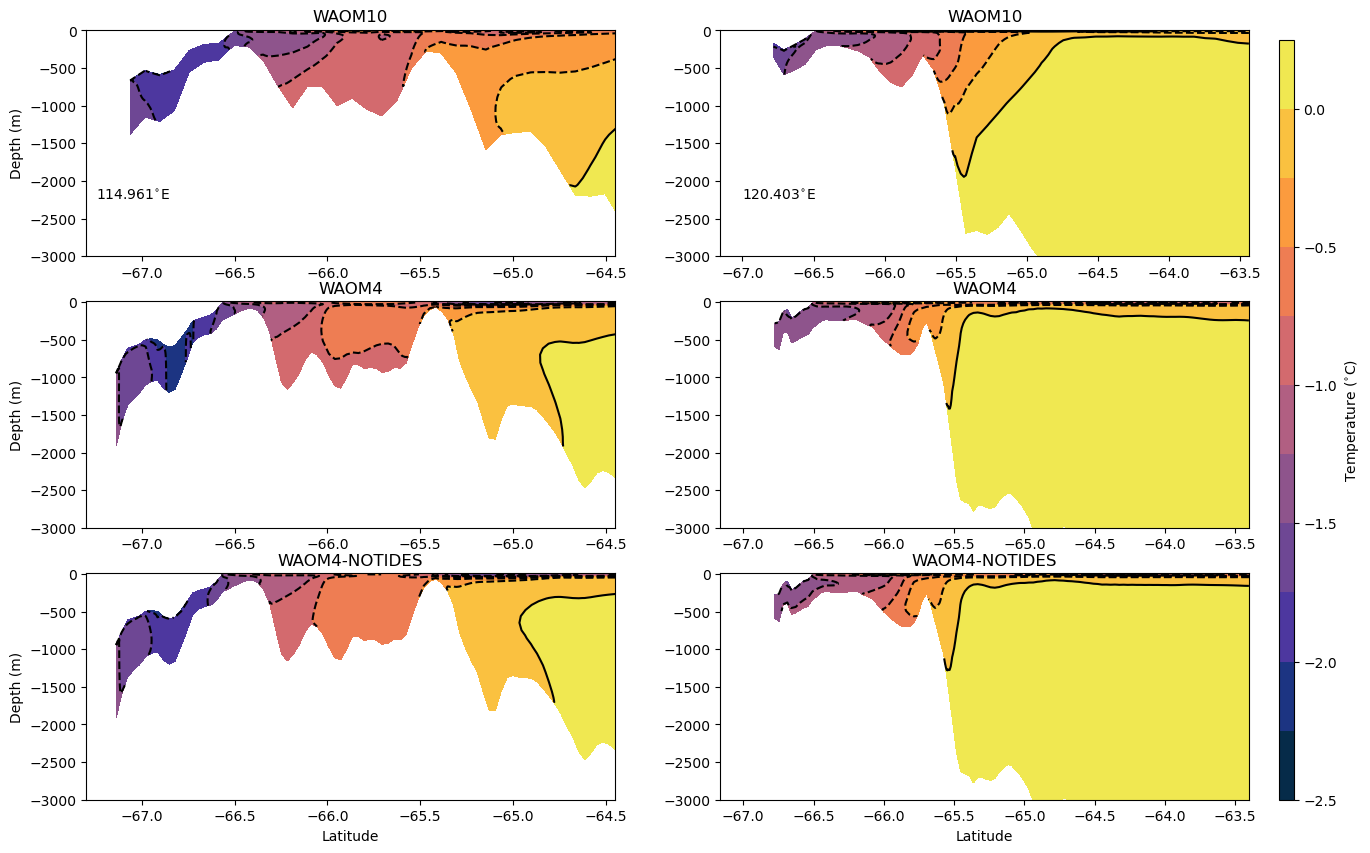

In [72]:
import cmocean

fig = plt.figure(figsize=(15,10))

ax1 = fig.add_subplot(321)
cc = plt.contourf(latp10,depp10.transpose().fillna(0),tempp10,np.arange(-2.5,.5,.25), cmap=cmocean.cm.thermal)
plt.contour(latp10,depp10.transpose().fillna(0),tempp10,np.arange(-2.5,.5,.25),colors='black')
# plt.pcolormesh(latp10,depp10.transpose().fillna(0),tempp10, vmin=tmin, vmax=tmax)
# plt.colorbar()
ax1.set_ylim(-3000,10)
ax1.set_xlim(-67.3,-64.45)
plt.text(-67.25,-2250,lonstr10 + "$^{\circ}$E")
ax1.set_title('WAOM10')
ax1.set_ylabel('Depth (m)')

ax2 = fig.add_subplot(323)
cc = plt.contourf(latp4,depp4.transpose().fillna(0),tempp4,np.arange(-2.5,.5,.25), cmap=cmocean.cm.thermal)
plt.contour(latp4,depp4.transpose().fillna(0),tempp4,np.arange(-2.5,.5,.25),colors='black')
# plt.pcolormesh(latp4,depp4.transpose().fillna(0),tempp4, vmin=tmin, vmax=tmax)
# plt.colorbar()
ax2.set_ylim(-3000,10)
ax2.set_xlim(-67.3,-64.45)
# plt.text(-67,-2400,lonstr4 + "$^{\circ}$E")
ax2.set_title('WAOM4')
ax2.set_ylabel('Depth (m)')

ax3 = fig.add_subplot(325)
cc = plt.contourf(latp4,depp4NT.transpose().fillna(0),tempp4NT,np.arange(-2.5,.5,.25), cmap=cmocean.cm.thermal)
plt.contour(latp4,depp4NT.transpose().fillna(0),tempp4NT,np.arange(-2.5,.5,.25),colors='black')
# plt.pcolormesh(latp4,depp4.transpose().fillna(0),tempp4, vmin=tmin, vmax=tmax)
# plt.colorbar()
ax3.set_ylim(-3000,10)
ax3.set_xlim(-67.3,-64.45)
# plt.text(-67,-2400,lonstr4 + "$^{\circ}$E")
ax3.set_title('WAOM4-NOTIDES')
ax3.set_xlabel('Latitude')
ax3.set_ylabel('Depth (m)')

ax1 = fig.add_subplot(322)
cc = plt.contourf(latp10b,depp10b.transpose().fillna(0),tempp10b,np.arange(-2.5,.5,.25), cmap=cmocean.cm.thermal)
plt.contour(latp10b,depp10b.transpose().fillna(0),tempp10b,np.arange(-2.5,.5,.25),colors='black')
# plt.pcolormesh(latp10b,depp10b.transpose().fillna(0),tempp10b, vmin=tmin, vmax=tmax)
# plt.colorbar()
ax1.set_ylim(-3000,10)
# ax1.set_xlim(-66.85,-65.4)
plt.text(-67,-2250,lonstr10b + "$^{\circ}$E")
ax1.set_title('WAOM10')
# ax1.set_ylabel('Depth (m)')

ax2 = fig.add_subplot(324)
cc = plt.contourf(latp4b,depp4b.transpose().fillna(0),tempp4b,np.arange(-2.5,.5,.25), cmap=cmocean.cm.thermal)
plt.contour(latp4b,depp4b.transpose().fillna(0),tempp4b,np.arange(-2.5,.5,.25),colors='black')
# plt.pcolormesh(latp4b,depp4b.transpose().fillna(0),tempp4b, vmin=tmin, vmax=tmax)
# plt.colorbar()
ax2.set_ylim(-3000,10)
# ax2.set_xlim(-66.85,-65.4)
# plt.text(-67,-2400,lonstr4 + "$^{\circ}$E")
ax2.set_title('WAOM4')
# ax2.set_ylabel('Depth (m)')

ax3 = fig.add_subplot(326)
cc = plt.contourf(latp4b,depp4NTb.transpose().fillna(0),tempp4NTb,np.arange(-2.5,.5,.25), cmap=cmocean.cm.thermal)
plt.contour(latp4b,depp4NTb.transpose().fillna(0),tempp4NTb,np.arange(-2.5,.5,.25),colors='black')
# plt.pcolormesh(latp4b,depp4NTb.transpose().fillna(0),tempp4b, vmin=tmin, vmax=tmax)
# plt.colorbar()
ax3.set_ylim(-3000,10)
# ax3.set_xlim(-66.85,-65.4)
# plt.text(-67,-2400,lonstr4 + "$^{\circ}$E")
ax3.set_title('WAOM4-NOTIDES')
ax3.set_xlabel('Latitude')
# ax3.set_ylabel('Depth (m)')

cbar_ax1 = fig.add_axes([0.92, 0.11, 0.01, 0.76])
fig.colorbar(cc, cax=cbar_ax1, orientation='vertical')
cbar_ax1.set_ylabel('Temperature ($^{\circ}$C)')#, labelpad=-35)

# plt.show()
name_fig='waom10x4x4-NOTIDE_Tcross_yr10_EAntTIS.png'
plt.savefig(fig_path + name_fig, dpi=300)


In [73]:
# plot TS-diag just for the transects:

In [76]:
# make grid for density contours
smin = 30 - (0.01 * 30)    #shflux_ctrl_subregR.min - (0.01 * shflux_ctrl_subregR.min)
smax = 36. + (0.01 * 36.)    #shflux_ctrl_subregR.max + (0.01 * shflux_ctrl_subregR.max)
tmin = -4. + (0.1 * -4.)       #temp_ctrl_subregR.min - (0.1 * temp_ctrl_subregR.max)
tmax = 5 + (0.1 * 5.)       #temp_ctrl_subregR.max + (0.1 * temp_ctrl_subregR.max)
print('tmin, tmax, smin, smax sizes=,', tmin, tmax, smin, smax)
# Calculate how many gridcells we need in the x and y dimensions
xdim = 30
ydim = 20
# Create empty grid of zeros
dens = np.zeros((ydim,xdim))
# Create temp and salt vectors of appropiate dimensions
ti = np.linspace(-4,5,ydim)
si = np.linspace(30,36,xdim)

Si, Ti = np.meshgrid(si, ti, sparse=False, indexing='ij')
# Loop to fill in grid with densities
for j in range(0,int(ydim)):
    for i in range(0, int(xdim)):
        dens[j,i]=gsw.rho(si[i],ti[j],2000) # sigma-2000
# Substract 1000 to convert to sigma-2
dens = dens - 1000

tmin, tmax, smin, smax sizes=, -4.4 5.5 29.7 36.36


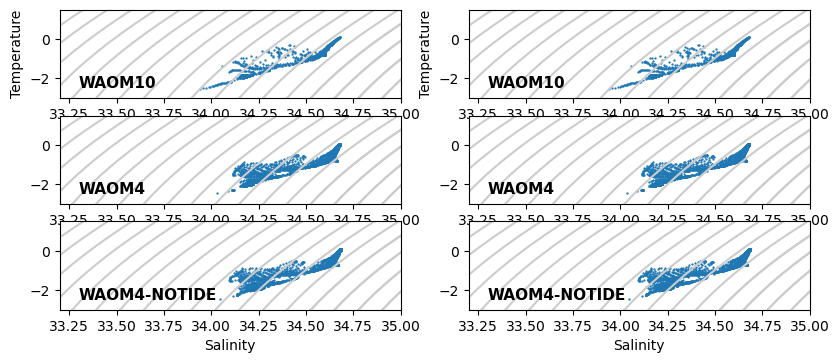

In [84]:
import cmocean

fig, ax = plt.subplots(nrows=3, ncols=2, figsize = (15, 5))
# normal isopycnals
for bb in range(0,3):
    for aa in range(0,2):
        CS1 = ax[bb,aa].contour(Si,Ti,dens.transpose(), levels=np.arange(35.5,38,.1),linestyles='solid', colors=[(.8,0.8,0.8)], linewidth=0.1)
        # ax[bb].clabel(CS1, CS1.levels, inline=True, fontsize=10)
        CS2 = ax[bb,aa].contour(Si,Ti,dens.transpose(), levels=np.arange(37.2,38,.1),linestyles='solid', colors=[(.8,0.8,0.8)], linewidth=0.1)
        # ax[bb,aa].clabel(CS2, CS2.levels, inline=True, fontsize=10)
        ax[bb,aa].set_xlim([33.2,35])
        ax[bb,aa].set_ylim([-3,1.5])
        ax[0,aa].set_ylabel('Temperature')
        ax[bb,aa].set_xlabel('Salinity')# East antarct.
            
sc = ax[0,0].scatter(saltp10,tempp10, marker="p", s=(72./fig.dpi)**2, label='Annual avg')#, cmap=cmocean.cm.deep, vmin=0, vmax=2000)
ax[0,0].text(33.3,-2.5,'WAOM10', fontsize=11, fontweight='bold')

sc = ax[1,0].scatter(saltp4,tempp4, marker="p", s=(72./fig.dpi)**2, label='Annual avg')#, cmap=cmocean.cm.deep, vmin=0, vmax=2000)
ax[1,0].text(33.3,-2.5,'WAOM4', fontsize=11, fontweight='bold')

sc = ax[2,0].scatter(saltp4NT,tempp4NT, marker="p", s=(72./fig.dpi)**2, label='Annual avg')#, cmap=cmocean.cm.deep, vmin=0, vmax=2000)
ax[2,0].text(33.3,-2.5,'WAOM4-NOTIDE', fontsize=11, fontweight='bold')

sc = ax[0,1].scatter(saltp10,tempp10, marker="p", s=(72./fig.dpi)**2, label='Annual avg')#, cmap=cmocean.cm.deep, vmin=0, vmax=2000)
ax[0,1].text(33.3,-2.5,'WAOM10', fontsize=11, fontweight='bold')

sc = ax[1,1].scatter(saltp4,tempp4, marker="p", s=(72./fig.dpi)**2, label='Annual avg')#, cmap=cmocean.cm.deep, vmin=0, vmax=2000)
ax[1,1].text(33.3,-2.5,'WAOM4', fontsize=11, fontweight='bold')

sc = ax[2,1].scatter(saltp4NT,tempp4NT, marker="p", s=(72./fig.dpi)**2, label='Annual avg')#, cmap=cmocean.cm.deep, vmin=0, vmax=2000)
ax[2,1].text(33.3,-2.5,'WAOM4-NOTIDE', fontsize=11, fontweight='bold')



# - cbar horiz
# cbar_ax1 = fig.add_axes([0.25, 0.2, 0.5, 0.01])
# fig.colorbar(sc, cax=cbar_ax1, orientation='horizontal')
# cbar_ax1.set_xlabel('Depth (m)')

plt.subplots_adjust(left=0.25, right=0.75, bottom=0.3, top=0.9)

name_fig="/g/data/hh5/tmp/access-om/fbd581/ROMS/postprocessing/figs/OHB_shelf/sigma_2/waom10x4x4NT_TSdiag_Tcross_yr10_EAntTIS.png"
plt.savefig(name_fig, dpi=300)